# Projeto Final MC886
## Imputação de dados de Pressão Arterial reais utilizando Redes Adversárias Generativas

#### Giovanne Lucas (173317), Luciano Fabris (173093) e Marta Fernandez (948383)

Exames de coleta de pressão arterial (PA) ao longo de um dia são os exames mais eficientes, segundo cardiologistas, para determinar padrões que caracterizam as disfunções cardíacas mais comuns e que, na sociedade brasileira, representam um dos maiores fatores de risco e índices de causas de morte. Entretanto, estes exames requerem condições de inatividade e dedicação, por parte do paciente, que nem sempre são possíveis. Este fator, por sua vez, faz com que cerca de 90% dos exames realizados sejam descartados, proporcionando enormes desperdícios financeiros, cronológicos e medicinais, visto que o diagnóstico precoce e início ágil dos tratamentos são imprescindíveis para aumentar as chances de regularização e recuperação dos pacientes. Dessa forma, evitar o descarte destes exames de maneira a possibilitar com que sejam utilizáveis mesmo em casos nos quais existem muitas medidas faltantes seria de extrema relevância.

Considerando este contexto, este projeto se propõem a explorar técnicas de aprendizado de máquina para a imputação de dados faltantes em exames de PA sem perca de propriedades relevantes para os principais diagnósticos médicos.

As pesquisas na literatura médica e de ciência da computação indicaram que a maneira mais adequada para abordar esta tentativa é utilizando a técnica de imputação através de [MisGANs](https://arxiv.org/abs/1902.09599).

Os esforços para realizar este estudo pode ser sumarizados nos seguintes tópicos:
  - tratamento de dados
  - aumentação de dados
  - implementação de uma [GAN](https://arxiv.org/abs/1406.2661)
  - implementação de uma [MisGAN](https://arxiv.org/abs/1902.09599)
  - implementação de um imputador que utiliza a MisGAN
  - anexos contendo:
    - implementações destas técnicas em dados mais simples e com datasets menos complexos

In [0]:
Este código foi feito com base na implementação da MisGAN disponivel em:

https://github.com/steveli/misgan/blob/master/misgan.ipynb
    
E também foi utilizado como base o código de *kroosen*, usuário do github para implementar GANS em keras:

https://github.com/kroosen/GAN-in-keras-on-mnist/blob/master/GAN-keras-mnist-MLP.ipynb

In [0]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf

Using TensorFlow backend.


#### 1. Tratamento de dados:

In [0]:
def show_pressure_entries(data):
    for exemplo in data:
        plt.plot(range(len(exemplo)), exemplo)
        plt.tight_layout()
        plt.show()

O total de dados é:  7711
O total de dados completos é:  108
O total de dados incompletos é:  7603
O numero de features é:  160
O menor numero de dados faltando é:  46
O maior numero de dados faltando é:  46
O maior valor é:  234.0
O menor valor é:  30.0


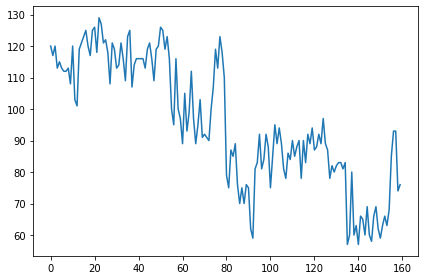

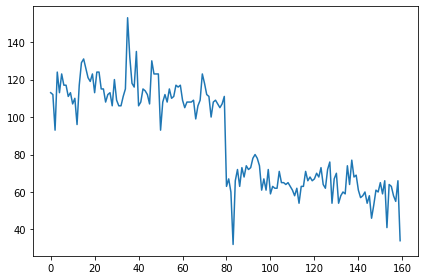

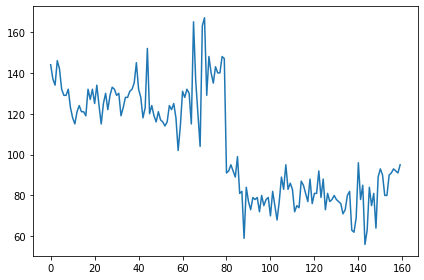

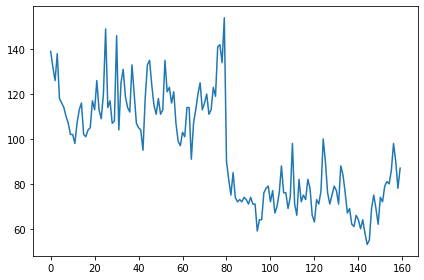

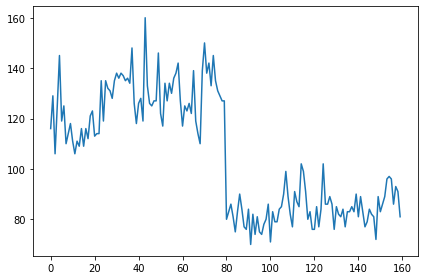

In [0]:
import pandas as pd

dados_base = pd.read_csv("base_pressao.csv") 
dados_pressao = dados_base.to_numpy()[:, 3:].astype(np.float64)

dados_pressao_completos = np.array([exemplo for exemplo in dados_pressao if not np.isnan(exemplo).any()])
# dados_pressao_completos = dados_pressao_completos / np.max(dados_pressao_completos)
dados_pressao_incompletos = np.array([exemplo for exemplo in dados_pressao if np.isnan(exemplo).any()]) 

m, n = np.shape(dados_pressao)
print('O total de dados é: ', m)
print('O total de dados completos é: ', len(dados_pressao_completos))
print('O total de dados incompletos é: ', len(dados_pressao_incompletos))
print('O numero de features é: ', n)
menor_exemplo = np.argmin(np.array([np.isnan(exemplo).any().sum() for exemplo in dados_pressao_incompletos]))
maior_exemplo = np.argmax(np.array([np.isnan(exemplo).any().sum() for exemplo in dados_pressao_incompletos]))
print('O menor numero de dados faltando é: ', np.isnan(dados_pressao_incompletos[menor_exemplo]).sum())
print('O maior numero de dados faltando é: ', np.isnan(dados_pressao_incompletos[maior_exemplo]).sum())

valor_maximo = np.max(np.nan_to_num(dados_pressao))
print('O maior valor é: ', np.max(dados_pressao_completos))
print('O menor valor é: ', np.min(dados_pressao_completos))

show_pressure_entries(dados_pressao_completos[:5])

#### 2. Aumentação de dados:

In [0]:
#Aumentação de dados com mixup
def mixup(data, alpha):
    m, n = np.shape(data)
    augmented_data = np.zeros((1, n))
    for first_entry in range(len(data)):
        for second_entry in range(len(data)):
            if first_entry != second_entry:
                new_data = (alpha * data[first_entry] + data[second_entry] * (1-alpha))
                augmented_data = np.vstack((augmented_data, new_data))
    return augmented_data[1:]

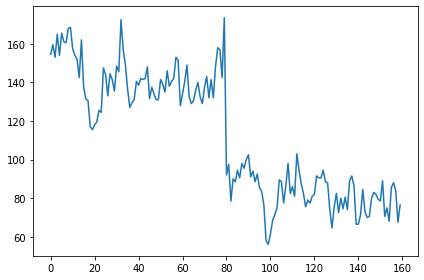

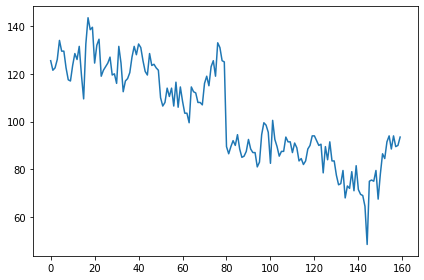

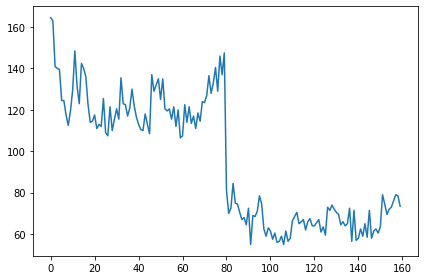

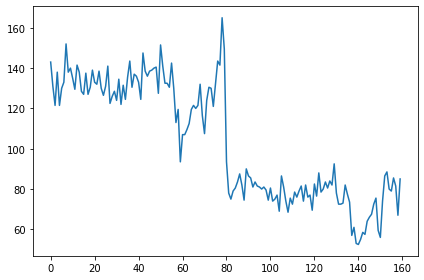

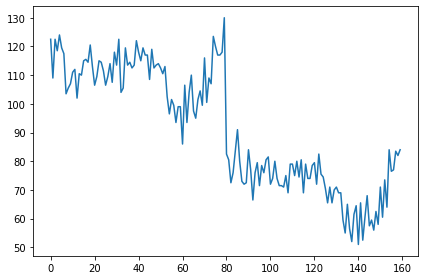

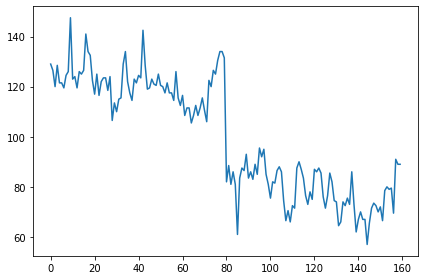

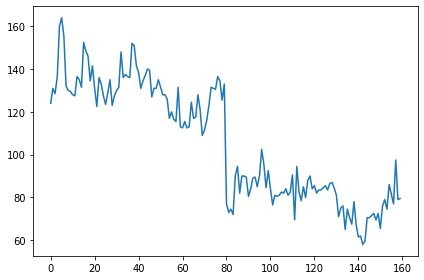

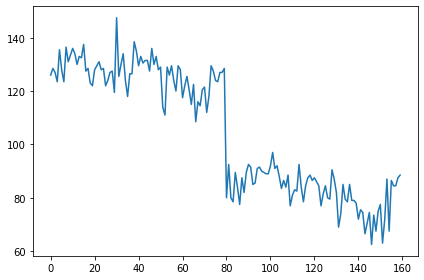

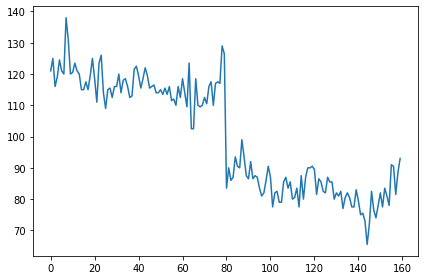

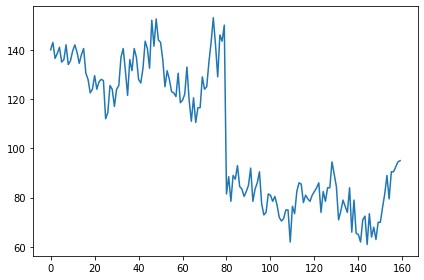

O total de dados aumentados é:  11556
O total de dados completos é:  11664


In [0]:
dados_completos_aumentados = np.zeros(n)
for alpha in [0.5]:
    dados_completos_aumentados = np.vstack((dados_completos_aumentados, mixup(dados_pressao_completos, alpha)))
dados_completos_aumentados = dados_completos_aumentados[1:]

show_pressure_entries(dados_completos_aumentados[np.random.randint(0, len(dados_completos_aumentados), size=10)])

print('O total de dados aumentados é: ', len(dados_completos_aumentados))
print('O total de dados completos é: ', len(dados_completos_aumentados) + len(dados_pressao_completos))

#### 3. Implementação de uma GAN:

Construção dos modelos de gerador, discriminador e GAN completa para dados e máscaras.

In [0]:
def mask_data(data, mask, tau=0):
    return mask * data + (1 - mask) * tau

In [0]:
import keras.backend as K

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [0]:
def build_data_generator(gx_noise_dimension, output_dimension, use_dropout = False, dropout_rate = 0.3):
    gx = Sequential()
    gx.add(Dense(160, input_dim=gx_noise_dimension, activation='linear'))
    gx.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        gx.add(Dropout(dropout_rate))
    gx.add(Dense(320, activation='linear'))
    gx.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        gx.add(Dropout(dropout_rate))
    gx.add(Dense(640, activation='linear'))
    gx.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        gx.add(Dropout(dropout_rate))
    gx.add(Dense(output_dimension, activation='linear'))
    gx.add(LeakyReLU(alpha=0.2))
    gx.compile(loss='binary_crossentropy', optimizer='adam')
    return gx

In [0]:
def build_mask_generator(gm_noise_dimension, output_dimension, use_dropout = False, dropout_rate = 0.3):
    gm = Sequential()
    gm.add(Dense(160, input_dim=gm_noise_dimension, activation='linear'))
    gm.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        gm.add(Dropout(dropout_rate))
    gm.add(Dense(320, activation='linear'))
    gm.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        gm.add(Dropout(dropout_rate))
    gm.add(Dense(640, activation='linear'))
    gm.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        gm.add(Dropout(dropout_rate))
    gm.add(Dense(output_dimension, activation='sigmoid'))  # Values between 0 and 1
    gm.compile(loss='binary_crossentropy', optimizer='adam')
    return gm

In [0]:
def build_data_discriminator(input_dim, use_dropout = False, dropout_rate = 0.3):
    dx = Sequential()
    dx.add(Dense(960, input_dim=input_dim, activation='linear'))
    dx.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        dx.add(Dropout(dropout_rate))
    dx.add(Dense(640, activation='linear'))
    dx.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        dx.add(Dropout(dropout_rate))
    dx.add(Dense(320, activation='linear'))
    dx.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        dx.add(Dropout(dropout_rate))
    dx.add(Dense(160, activation='linear'))
    dx.add(LeakyReLU(alpha=0.2))
    dx.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
    dx.compile(loss='binary_crossentropy', optimizer='adam')
    return dx

In [0]:
def build_masks_discriminator(input_dim, use_dropout = False, dropout_rate = 0.3):
    dm = Sequential()
    dm.add(Dense(960, input_dim=input_dim, activation='linear'))
    dm.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        dm.add(Dropout(dropout_rate))
    dm.add(Dense(640, activation='linear'))
    dm.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        dm.add(Dropout(dropout_rate))
    dm.add(Dense(320, activation='linear'))
    dm.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        dm.add(Dropout(dropout_rate))
    dm.add(Dense(160, activation='linear'))
    dm.add(LeakyReLU(alpha=0.2))
    dm.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
    dm.compile(loss='binary_crossentropy', optimizer='adam')
    return dm

In [0]:
def build_gan_data(gx_noise_dimension, output_dimension, use_dropout=False, dropout_rate=0.3):
    gx = build_data_generator(gx_noise_dimension, output_dimension, use_dropout, dropout_rate)
    dx = build_data_discriminator(output_dimension, use_dropout, dropout_rate)
    dx.trainable = False;
    inputsGx = Input(shape=(gx_noise_dimension,)) 
    hiddenGx = gx(inputsGx)
    outputGx = dx(hiddenGx)
    ganX = Model(inputsGx, outputGx)
    ganX.compile(loss='binary_crossentropy', optimizer='adam')
    return gx, dx, ganX

In [0]:
def build_gan_mask(gm_noise_dimension, output_dimension):
    gm = build_mask_generator(gm_noise_dimension, output_dimension)
    dm = build_masks_discriminator(output_dimension)
    dm.trainable = False;
    inputsGm = Input(shape=(gm_noise_dimension,))
    hiddenGm = gm(inputsGm)
    outputGm = dm(hiddenGm)
    ganM = Model(inputsGm, outputGm)
    ganM.compile(loss='binary_crossentropy', optimizer='adam')
    return gm, dm, ganM

Funções de utilidade para as GANs.


In [0]:
def generate_noise(size, noise_dimension):
    return np.random.normal(0, 1, size=(size, noise_dimension))

In [0]:
def build_discriminator_batch_input(data, generator, batch_indexes, noise_dimension):
    size = len(batch_indexes)
    generated_input = generator.predict(generate_noise(size, noise_dimension))
    return np.vstack((data[batch_indexes], generated_input))

In [0]:
def build_discriminator_labels(batch_size, label_smothing_coef):
    y = np.zeros(2*batch_size)
    y[:batch_size] = label_smothing_coef  # One-sided label smoothing
    return y

Funções para fazer o treinamento alternado do gerador e do discriminador segundo a esquemática das GANs.

In [0]:
def train_generator(gan, discriminator, batch_size, noise_dimension):
    return gan.train_on_batch(generate_noise(batch_size, noise_dimension), np.ones(batch_size))

In [0]:
def train_discriminator(discriminator, inputs, labels):
    return discriminator.train_on_batch(inputs, labels)

Funções para fazer o plot dos valores gerados de exames e dos valores da função de custo ao longo das épocas.

In [0]:
def plot_generated_pressures(generator, size, noise_dimension):
    generated_pressures = generator.predict(generate_noise(size, noise_dimension))
    for pressure in generated_pressures:
        plt.plot(range(len(pressure)), pressure)
        plt.tight_layout()
        plt.show()

In [0]:
def plot_loss(losses):
    d_loss = [v for v in losses["D"]]
    g_loss = [v for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Função para realizar efetivamente o ciclo de treinamento de uma GAN.

In [0]:
def train_normal_gan(X_train, g, d, gan, epochs=1000, plt_frq=100, BATCH_SIZE=128):
    # Set up a vector (dict) to store the losses
    losses = {"D":[], "G":[]}
    m, n = np.shape(X_train)
    noise_dimension = n
    batchCount = int(m / BATCH_SIZE)
    g.summary()
    d.summary()
    gan.summary()
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        plot_generated_pressures(g, 1, noise_dimension)
        for _ in range(batchCount):
            # Create a batch by drawing random index numbers from the training set
            batch_indexes = np.random.randint(0, m, size=BATCH_SIZE)

            # Build discriminators inputs
            d_inputs = build_discriminator_batch_input(X_train, g, batch_indexes, noise_dimension)

            # Build batch labels
            y = build_discriminator_labels(BATCH_SIZE, label_smothing_coef=0.9)

            # Train discriminator on generated output
            d_loss = train_discriminator(d, d_inputs, y)

            # Train data generator
            g_loss = train_generator(gan, d, BATCH_SIZE, noise_dimension)

        print('-'*10, "Losses epoch ", e, '-'*10)
        print('-'*10, 'D Metrics names: ', d.metrics_names, '-'*10)
        print('-'*8, "d_loss: ", d_loss , '-'*8)
        print('-'*10, 'G Metrics names: ', g.metrics_names, '-'*10)
        print('-'*8, "g_loss: ", g_loss , '-'*8)
        print('-'*10, "------" , '-'*10)
        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)
    plot_loss(losses)

Preparação dos modelos e execução do treino.

In [0]:
X_train = np.vstack((dados_pressao_completos, dados_completos_aumentados))

output_dimension = n
noise_dimension = n

g, d, gan = build_gan_data(noise_dimension, output_dimension, use_dropout=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 160)               25760     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 160)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 320)               51520     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 320)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 640)              

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


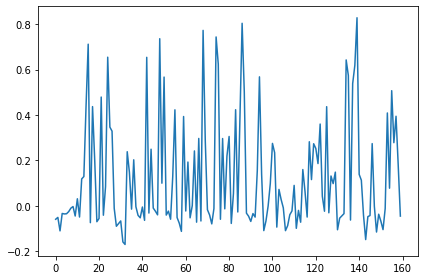

---------- Losses epoch  1 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.40397638 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.4196827 --------
---------- ------ ----------
--------------- Epoch 2 ---------------


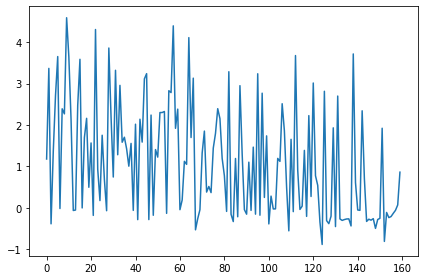

---------- Losses epoch  2 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.4237203 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.8177853 --------
---------- ------ ----------
--------------- Epoch 3 ---------------


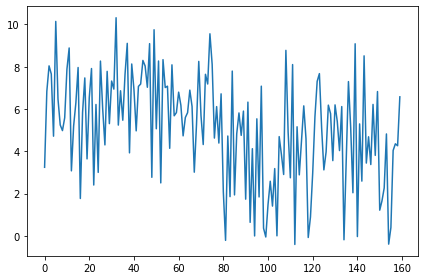

---------- Losses epoch  3 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.29827413 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  3.061038 --------
---------- ------ ----------
--------------- Epoch 4 ---------------


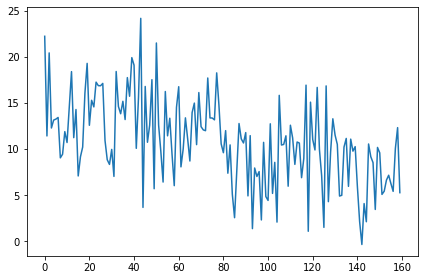

---------- Losses epoch  4 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.2925177 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  5.011297 --------
---------- ------ ----------
--------------- Epoch 5 ---------------


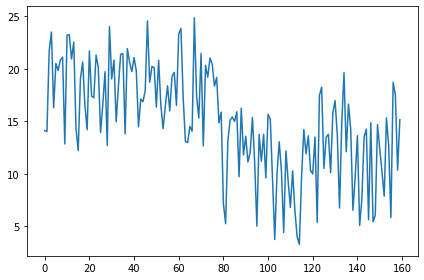

---------- Losses epoch  5 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.38036722 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.7155988 --------
---------- ------ ----------
--------------- Epoch 6 ---------------


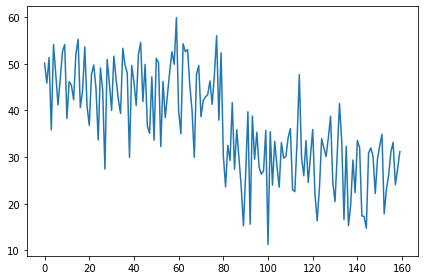

---------- Losses epoch  6 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.45234868 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  4.222395 --------
---------- ------ ----------
--------------- Epoch 7 ---------------


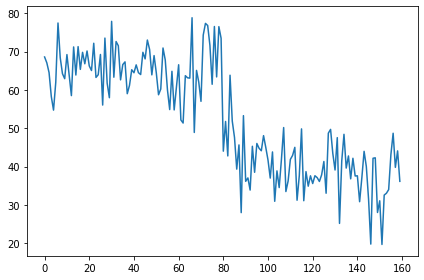

---------- Losses epoch  7 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.73742986 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  2.133851 --------
---------- ------ ----------
--------------- Epoch 8 ---------------


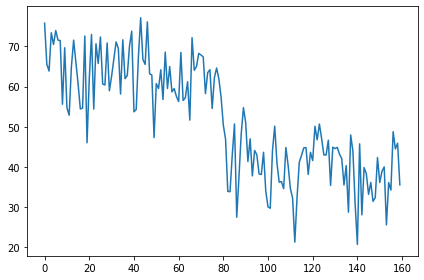

---------- Losses epoch  8 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  1.488271 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.6539316 --------
---------- ------ ----------
--------------- Epoch 9 ---------------


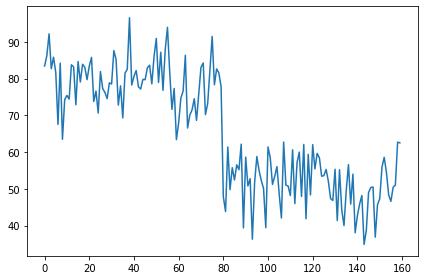

---------- Losses epoch  9 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.96045125 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.87553924 --------
---------- ------ ----------
--------------- Epoch 10 ---------------


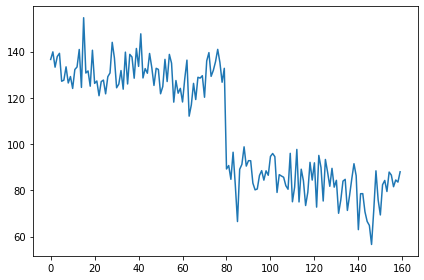

---------- Losses epoch  10 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.8632908 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.72253937 --------
---------- ------ ----------
--------------- Epoch 11 ---------------


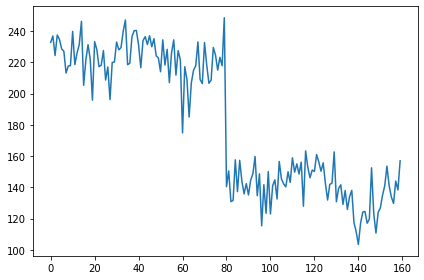

---------- Losses epoch  11 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.57976234 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  3.5800638 --------
---------- ------ ----------
--------------- Epoch 12 ---------------


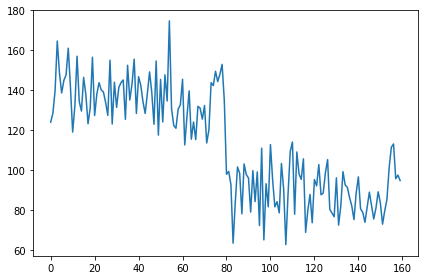

---------- Losses epoch  12 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.4369045 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  2.0787723 --------
---------- ------ ----------
--------------- Epoch 13 ---------------


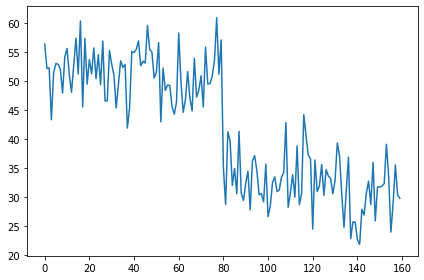

---------- Losses epoch  13 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.6569169 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.79412204 --------
---------- ------ ----------
--------------- Epoch 14 ---------------


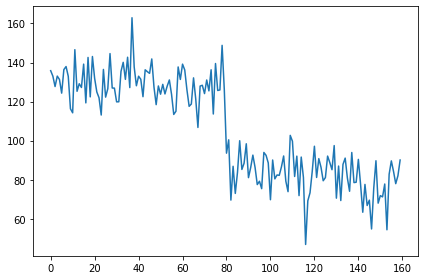

---------- Losses epoch  14 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.74427724 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.1335909 --------
---------- ------ ----------
--------------- Epoch 15 ---------------


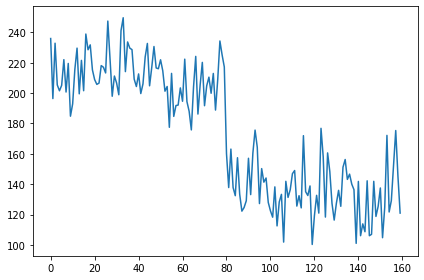

---------- Losses epoch  15 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.600269 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.3293545 --------
---------- ------ ----------
--------------- Epoch 16 ---------------


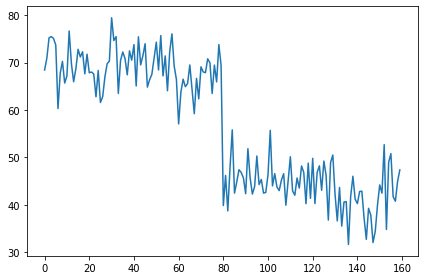

---------- Losses epoch  16 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.59217715 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.83277476 --------
---------- ------ ----------
--------------- Epoch 17 ---------------


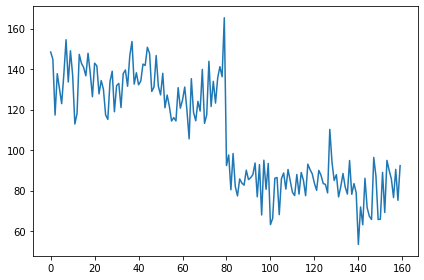

---------- Losses epoch  17 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.8961601 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.6523098 --------
---------- ------ ----------
--------------- Epoch 18 ---------------


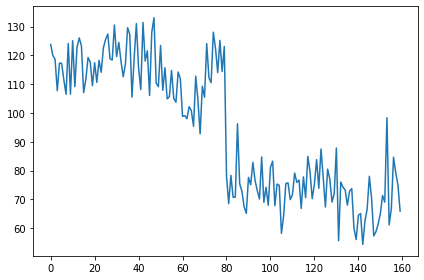

---------- Losses epoch  18 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.31879663 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  3.1816928 --------
---------- ------ ----------
--------------- Epoch 19 ---------------


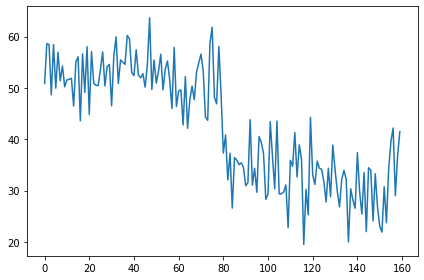

---------- Losses epoch  19 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.5277338 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.6365863 --------
---------- ------ ----------
--------------- Epoch 20 ---------------


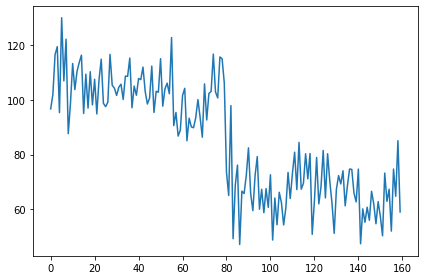

---------- Losses epoch  20 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  1.3508763 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.33895558 --------
---------- ------ ----------
--------------- Epoch 21 ---------------


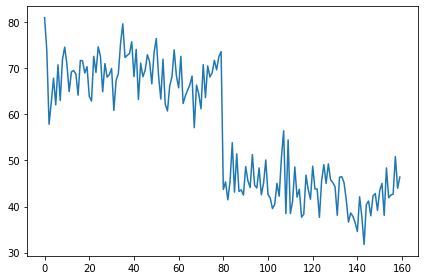

---------- Losses epoch  21 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.7920412 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.0156926 --------
---------- ------ ----------
--------------- Epoch 22 ---------------


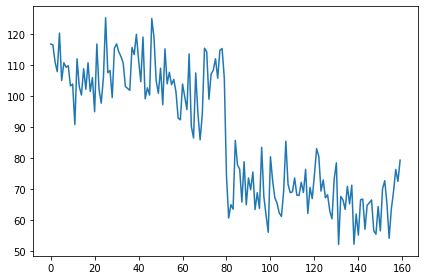

---------- Losses epoch  22 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.59396756 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.5833743 --------
---------- ------ ----------
--------------- Epoch 23 ---------------


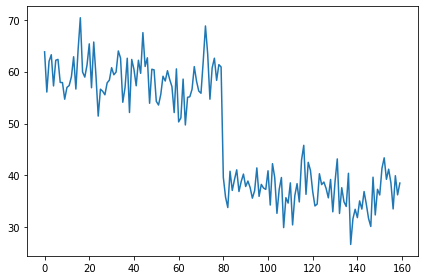

---------- Losses epoch  23 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.80798197 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.1837647 --------
---------- ------ ----------
--------------- Epoch 24 ---------------


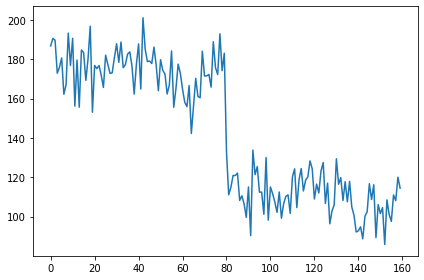

---------- Losses epoch  24 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.52005947 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.99700344 --------
---------- ------ ----------
--------------- Epoch 25 ---------------


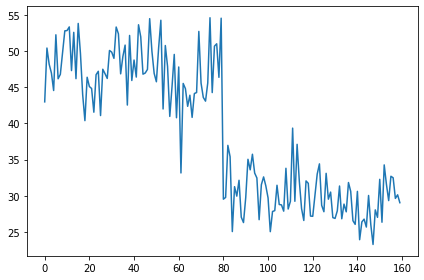

---------- Losses epoch  25 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  1.1416051 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  18.748306 --------
---------- ------ ----------
--------------- Epoch 26 ---------------


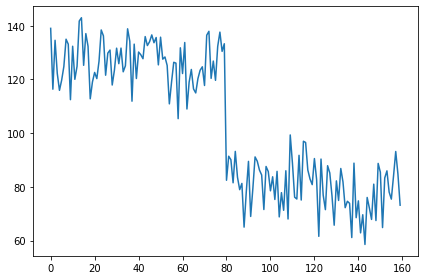

---------- Losses epoch  26 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.61225224 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.81117594 --------
---------- ------ ----------
--------------- Epoch 27 ---------------


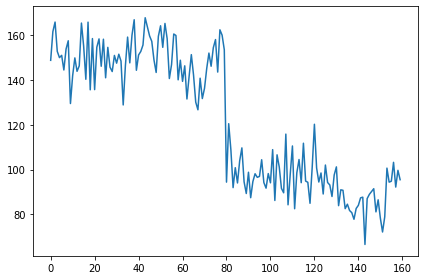

---------- Losses epoch  27 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.9220731 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.7321212 --------
---------- ------ ----------
--------------- Epoch 28 ---------------


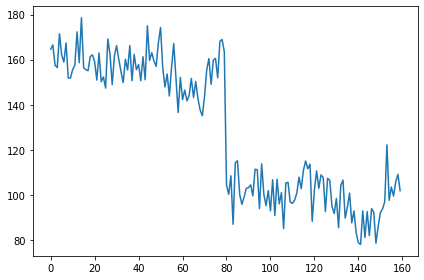

---------- Losses epoch  28 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.43984482 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  2.0334983 --------
---------- ------ ----------
--------------- Epoch 29 ---------------


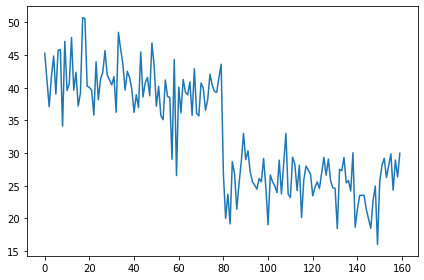

---------- Losses epoch  29 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.6136992 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.0604575 --------
---------- ------ ----------
--------------- Epoch 30 ---------------


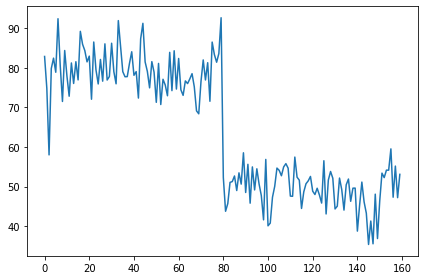

---------- Losses epoch  30 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.31632853 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  4.240679 --------
---------- ------ ----------
--------------- Epoch 31 ---------------


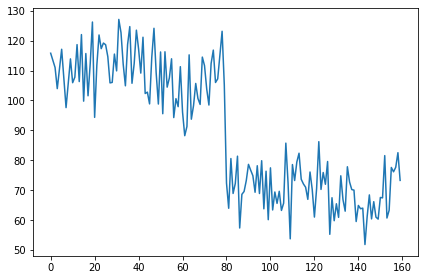

---------- Losses epoch  31 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.69509196 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.476144 --------
---------- ------ ----------
--------------- Epoch 32 ---------------


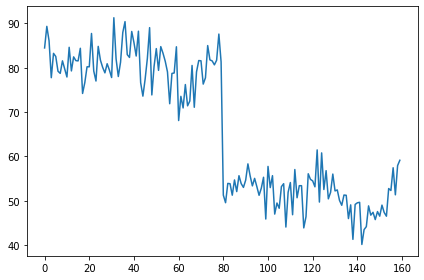

---------- Losses epoch  32 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.20339525 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  13.241531 --------
---------- ------ ----------
--------------- Epoch 33 ---------------


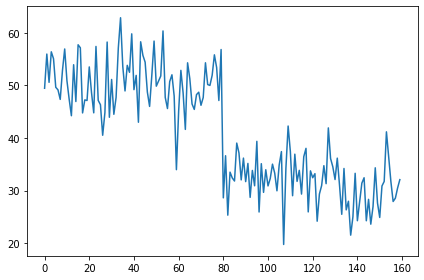

---------- Losses epoch  33 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.65492904 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.3948722 --------
---------- ------ ----------
--------------- Epoch 34 ---------------


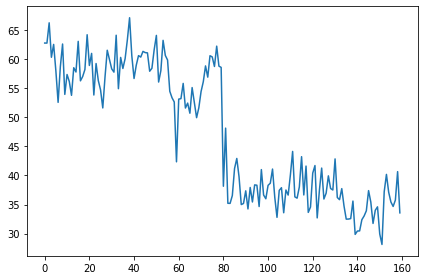

---------- Losses epoch  34 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  1.2127357 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  2.7125878 --------
---------- ------ ----------
--------------- Epoch 35 ---------------


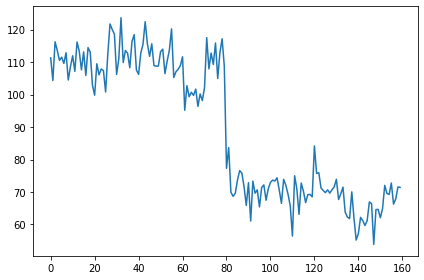

---------- Losses epoch  35 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.6953522 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.5000043 --------
---------- ------ ----------
--------------- Epoch 36 ---------------


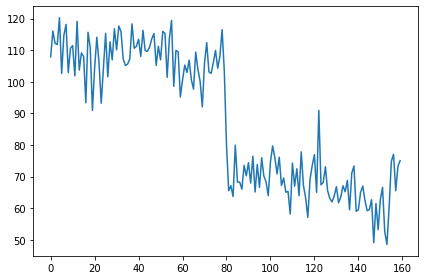

---------- Losses epoch  36 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.40672162 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.2211411 --------
---------- ------ ----------
--------------- Epoch 37 ---------------


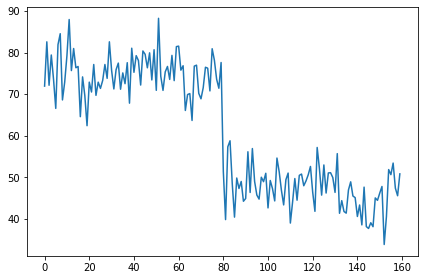

---------- Losses epoch  37 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.7148759 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.9363334 --------
---------- ------ ----------
--------------- Epoch 38 ---------------


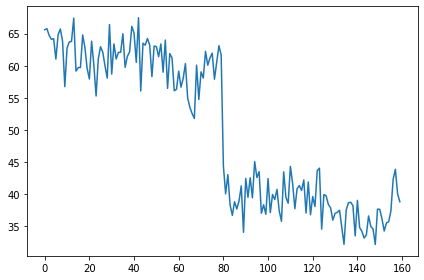

---------- Losses epoch  38 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.70203817 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.1721478 --------
---------- ------ ----------
--------------- Epoch 39 ---------------


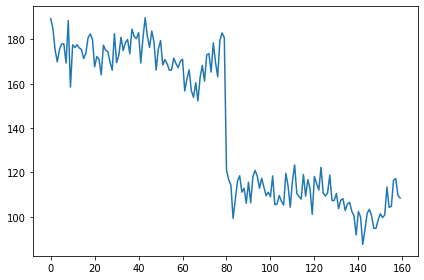

---------- Losses epoch  39 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  2.3470051 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  2.8391342 --------
---------- ------ ----------
--------------- Epoch 40 ---------------


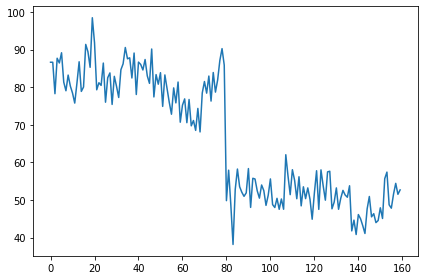

---------- Losses epoch  40 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.52281064 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.9957905 --------
---------- ------ ----------
--------------- Epoch 41 ---------------


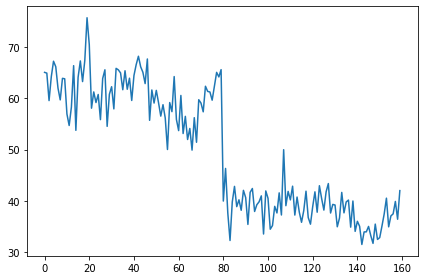

---------- Losses epoch  41 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.7317193 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.67507344 --------
---------- ------ ----------
--------------- Epoch 42 ---------------


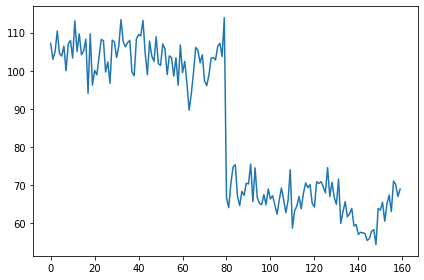

---------- Losses epoch  42 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.8285006 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.9138516 --------
---------- ------ ----------
--------------- Epoch 43 ---------------


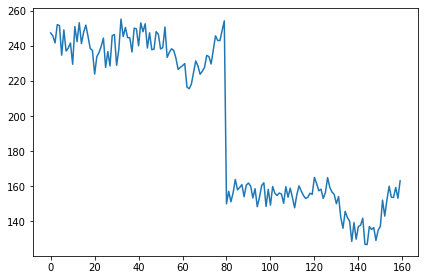

---------- Losses epoch  43 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.780357 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.5287127 --------
---------- ------ ----------
--------------- Epoch 44 ---------------


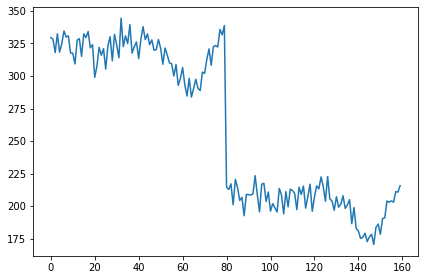

---------- Losses epoch  44 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.7485009 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.2888496 --------
---------- ------ ----------
--------------- Epoch 45 ---------------


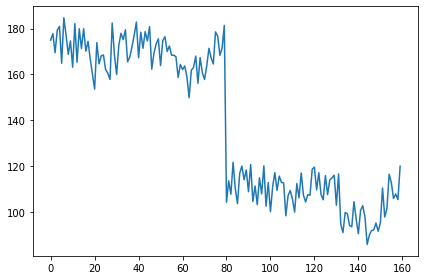

---------- Losses epoch  45 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  1.2157319 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  3.3468194 --------
---------- ------ ----------
--------------- Epoch 46 ---------------


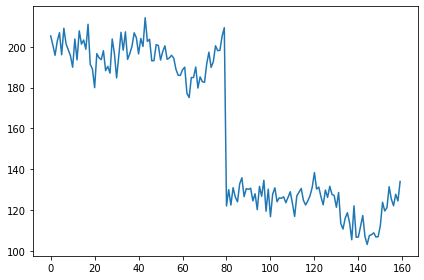

---------- Losses epoch  46 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.69572556 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.9998324 --------
---------- ------ ----------
--------------- Epoch 47 ---------------


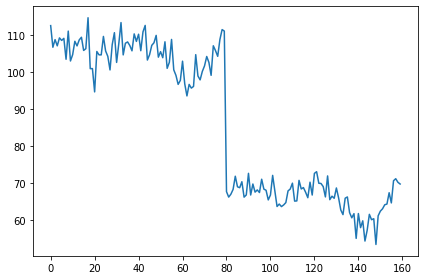

---------- Losses epoch  47 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.70650077 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.8848027 --------
---------- ------ ----------
--------------- Epoch 48 ---------------


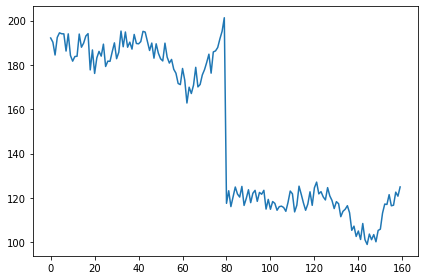

---------- Losses epoch  48 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.7604644 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.9431335 --------
---------- ------ ----------
--------------- Epoch 49 ---------------


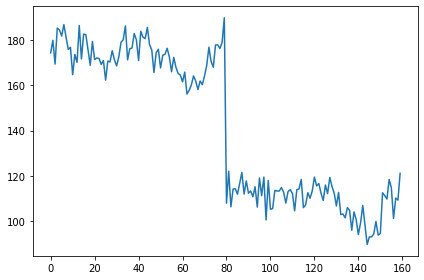

---------- Losses epoch  49 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.69162697 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.7980653 --------
---------- ------ ----------
--------------- Epoch 50 ---------------


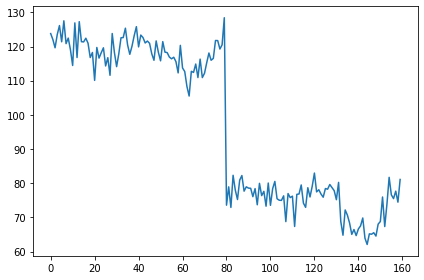

---------- Losses epoch  50 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.7979498 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.54698986 --------
---------- ------ ----------


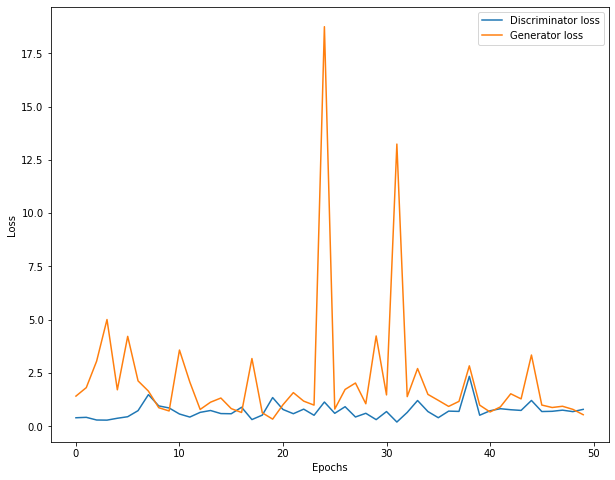

In [0]:
train_normal_gan(X_train, g, d, gan, 50, 10, 128)

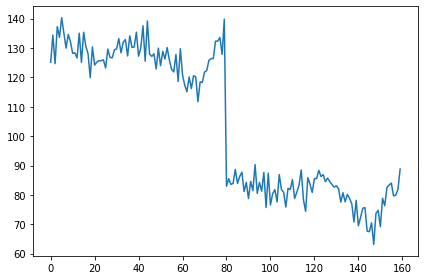

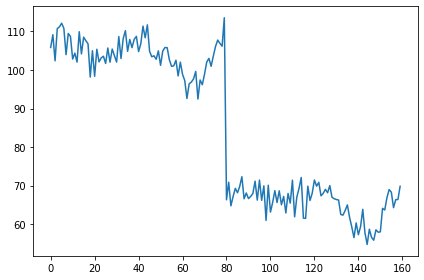

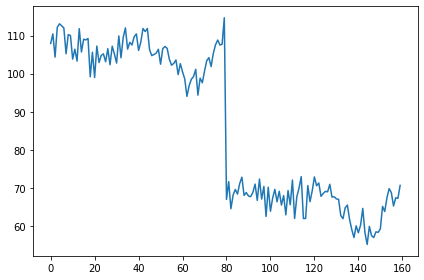

In [0]:
#Teste de resultados para a gan simples

numero_de_amostras = 3
amostras_geradas = g.predict(generate_noise(numero_de_amostras, noise_dimension))
show_pressure_entries(amostras_geradas)

#### 4. Implementação de uma MisGAN utilizando a base de dados original:

Função para exibir o modelo e o treinamento feito na construção da MisGAN.

In [0]:
def print_summary(epochs, BATCH_SIZE, batchCount, gx, dx, ganX, gm, dm, ganM):
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    print('-'*10, '-'*5, '-'*10)
    print('-'*10, "Data generator", '-'*10)
    gx.summary()
    print('-'*10, "Data discriminator", '-'*10)
    dx.summary()
    print('-'*10, "Data GAN", '-'*10)
    ganX.summary()
    print('-'*10, "Mask generator", '-'*10)
    gm.summary()
    print('-'*10, "Mask discriminator", '-'*10)
    dm.summary()
    print('-'*10, "Mask GAN", '-'*10)
    ganM.summary()
    print('-'*10, '-'*5, '-'*10)

Função para efetivamente fazer o treinamento da MisGAN.

In [0]:
def train_misgan_generation(X_train, X_Masks, gx, dx, ganX, gm, dm, ganM, epochs=1000, plt_frq=100, BATCH_SIZE=128):
    # Set up a vector (dict) to store the losses
    losses_data = {"D":[], "G":[]}
    losses_mask = {"D":[], "G":[]}
    m, n = np.shape(X_train)
    gm_noise_dimension = gx_noise_dimension = n
    batchCount = int(m / BATCH_SIZE)
    print_summary(epochs, BATCH_SIZE, batchCount, gx, dx, ganX, gm, dm, ganM)
  
    for e in range(1, epochs+1):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
            plot_generated_pressures(gx, 1, gx_noise_dimension)
        for _ in range(batchCount):
            # Create a batch by drawing random index numbers from the training set
            batch_indexes = np.random.randint(0, m, size=BATCH_SIZE)

            # Build discriminators inputs
            dx_inputs = build_discriminator_batch_input(X_train, gx, batch_indexes, gx_noise_dimension)
            dm_inputs = build_discriminator_batch_input(X_Masks, gm, batch_indexes, gm_noise_dimension)

            # Build batch labels
            y = build_discriminator_labels(BATCH_SIZE, label_smothing_coef=0.9)

            # Train discriminator on generated output
            dm_loss = train_discriminator(dm, dm_inputs, y)

            # Train discriminator on generated output
            dx_inputs = mask_data(dx_inputs, dm_inputs, tau=0)
            dx_loss = train_discriminator(dx, dx_inputs, y)

            # Train data generator
            gx_loss = train_generator(ganX, dx, BATCH_SIZE, gx_noise_dimension)

            # Train mask generator
            gm_loss = train_generator(ganM, dm, BATCH_SIZE, gm_noise_dimension)
        print('-'*10, "Losses epoch ", e, '-'*10)
        print('-'*10, 'Metrics names: ', gx.metrics_names, '-'*10)
        print('-'*8, "dx_loss: ", dx_loss , '-'*8)
        print('-'*8, "gx_loss: ", gx_loss , '-'*8)
        print('-'*8, "dm_loss: ", dm_loss , '-'*8)
        print('-'*8, "gm_loss: ", gm_loss , '-'*8)
        print('-'*10, "------" , '-'*10)
        # Only store losses from final batch of epoch
        losses_data["D"].append(dx_loss)
        losses_data["G"].append(gx_loss)
        losses_mask["D"].append(dm_loss)
        losses_mask["G"].append(gm_loss)
    plot_loss(losses_data)
    plot_loss(losses_mask)

In [0]:
def get_masks(data):
    return np.array(np.invert([np.isnan(exemplo) for exemplo in data])).astype(int)

Epochs: 100
Batch size: 19267
Batches per epoch: 1
---------- ----- ----------
---------- Data generator ----------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 160)               25760     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 160)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 320)               51520     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 320)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 640)               205440    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 640)               0         
____

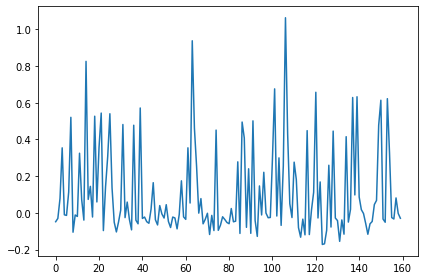

---------- Losses epoch  1 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  1.1482311 --------
-------- gx_loss:  0.8670048 --------
-------- dm_loss:  0.6807525 --------
-------- gm_loss:  0.10716571 --------
---------- ------ ----------
---------- Losses epoch  2 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  134.68115 --------
-------- gx_loss:  0.68525237 --------
-------- dm_loss:  1.4817835 --------
-------- gm_loss:  0.53821355 --------
---------- ------ ----------
---------- Losses epoch  3 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  23.022284 --------
-------- gx_loss:  0.6261476 --------
-------- dm_loss:  0.7029734 --------
-------- gm_loss:  0.93200666 --------
---------- ------ ----------
---------- Losses epoch  4 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  10.740635 --------
-------- gx_loss:  0.5643164 --------
-------- dm_loss:  0.7738102 --------

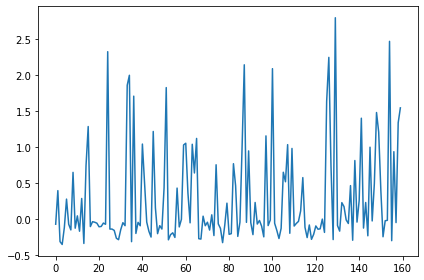

---------- Losses epoch  10 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  5.418773 --------
-------- gx_loss:  0.32706705 --------
-------- dm_loss:  0.64926416 --------
-------- gm_loss:  0.6951576 --------
---------- ------ ----------
---------- Losses epoch  11 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  7.6283865 --------
-------- gx_loss:  0.16247427 --------
-------- dm_loss:  0.63633853 --------
-------- gm_loss:  0.6255489 --------
---------- ------ ----------
---------- Losses epoch  12 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  13.03727 --------
-------- gx_loss:  0.07698389 --------
-------- dm_loss:  0.645323 --------
-------- gm_loss:  0.70101416 --------
---------- ------ ----------
---------- Losses epoch  13 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  16.059135 --------
-------- gx_loss:  0.04274861 --------
-------- dm_loss:  0.63606983 ---

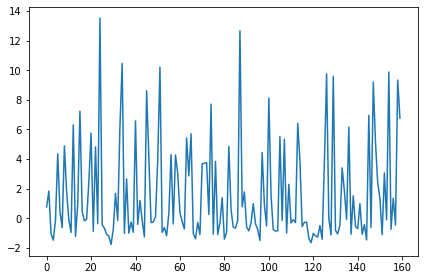

---------- Losses epoch  20 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  8.860955 --------
-------- gx_loss:  0.07944239 --------
-------- dm_loss:  0.735987 --------
-------- gm_loss:  0.69655037 --------
---------- ------ ----------
---------- Losses epoch  21 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  6.501558 --------
-------- gx_loss:  0.012244207 --------
-------- dm_loss:  0.7617477 --------
-------- gm_loss:  0.5624961 --------
---------- ------ ----------
---------- Losses epoch  22 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  11.386776 --------
-------- gx_loss:  0.0039253905 --------
-------- dm_loss:  0.78363883 --------
-------- gm_loss:  0.5944164 --------
---------- ------ ----------
---------- Losses epoch  23 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  14.341713 --------
-------- gx_loss:  0.0021825961 --------
-------- dm_loss:  0.7775677 

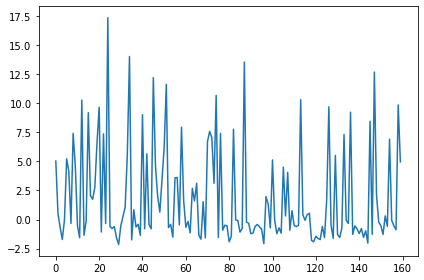

---------- Losses epoch  30 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  5.0583673 --------
-------- gx_loss:  0.8104068 --------
-------- dm_loss:  0.50608766 --------
-------- gm_loss:  1.7380885 --------
---------- ------ ----------
---------- Losses epoch  31 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  1.4026293 --------
-------- gx_loss:  2.5686195 --------
-------- dm_loss:  0.44990483 --------
-------- gm_loss:  2.1427886 --------
---------- ------ ----------
---------- Losses epoch  32 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  25.651714 --------
-------- gx_loss:  1.6012038 --------
-------- dm_loss:  0.38169125 --------
-------- gm_loss:  2.993509 --------
---------- ------ ----------
---------- Losses epoch  33 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  3.3788378 --------
-------- gx_loss:  0.36065176 --------
-------- dm_loss:  0.32312188 ----

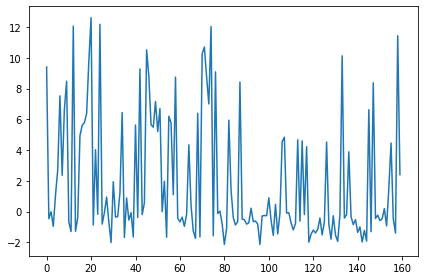

---------- Losses epoch  40 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  10.679401 --------
-------- gx_loss:  0.030922944 --------
-------- dm_loss:  1.0922484 --------
-------- gm_loss:  2.3943114 --------
---------- ------ ----------
---------- Losses epoch  41 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  9.736345 --------
-------- gx_loss:  0.06045583 --------
-------- dm_loss:  0.52101624 --------
-------- gm_loss:  5.2872434 --------
---------- ------ ----------
---------- Losses epoch  42 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  8.627455 --------
-------- gx_loss:  0.1323202 --------
-------- dm_loss:  0.63527167 --------
-------- gm_loss:  5.4385557 --------
---------- ------ ----------
---------- Losses epoch  43 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  7.3529196 --------
-------- gx_loss:  0.2952482 --------
-------- dm_loss:  0.47942674 ----

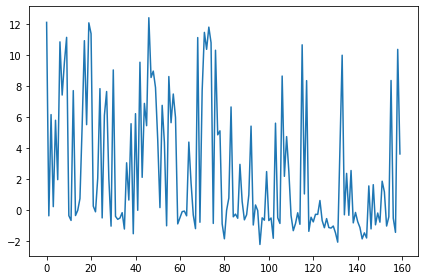

---------- Losses epoch  50 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.6919884 --------
-------- gx_loss:  1.0831596 --------
-------- dm_loss:  0.402129 --------
-------- gm_loss:  5.2601376 --------
---------- ------ ----------
---------- Losses epoch  51 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  1.4831722 --------
-------- gx_loss:  0.7169532 --------
-------- dm_loss:  0.6626586 --------
-------- gm_loss:  6.010464 --------
---------- ------ ----------
---------- Losses epoch  52 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  1.8848367 --------
-------- gx_loss:  0.56635225 --------
-------- dm_loss:  0.6857195 --------
-------- gm_loss:  7.1788583 --------
---------- ------ ----------
---------- Losses epoch  53 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  2.005721 --------
-------- gx_loss:  0.49722663 --------
-------- dm_loss:  1.7346903 --------


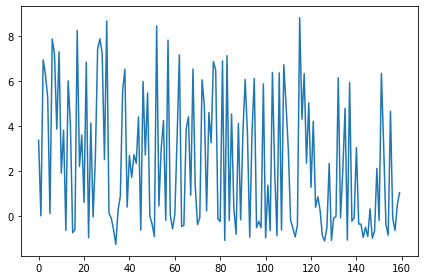

---------- Losses epoch  60 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.6069432 --------
-------- gx_loss:  0.49720058 --------
-------- dm_loss:  0.62873393 --------
-------- gm_loss:  3.523718 --------
---------- ------ ----------
---------- Losses epoch  61 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.9518671 --------
-------- gx_loss:  0.43164527 --------
-------- dm_loss:  0.4861751 --------
-------- gm_loss:  4.5399528 --------
---------- ------ ----------
---------- Losses epoch  62 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  1.1796942 --------
-------- gx_loss:  0.39678255 --------
-------- dm_loss:  0.49788782 --------
-------- gm_loss:  4.6748457 --------
---------- ------ ----------
---------- Losses epoch  63 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  1.2541351 --------
-------- gx_loss:  0.39101276 --------
-------- dm_loss:  0.3288593 ---

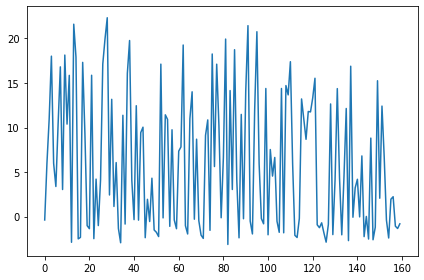

---------- Losses epoch  70 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.6900044 --------
-------- gx_loss:  0.36517036 --------
-------- dm_loss:  0.26149777 --------
-------- gm_loss:  10.484473 --------
---------- ------ ----------
---------- Losses epoch  71 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.80247515 --------
-------- gx_loss:  0.34296483 --------
-------- dm_loss:  0.2659277 --------
-------- gm_loss:  9.946599 --------
---------- ------ ----------
---------- Losses epoch  72 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.8221679 --------
-------- gx_loss:  0.34598798 --------
-------- dm_loss:  0.29575145 --------
-------- gm_loss:  9.965957 --------
---------- ------ ----------
---------- Losses epoch  73 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.73361033 --------
-------- gx_loss:  0.38331833 --------
-------- dm_loss:  0.3106844 --

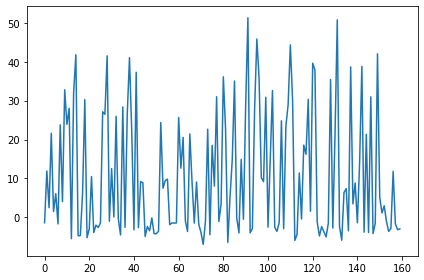

---------- Losses epoch  80 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.563748 --------
-------- gx_loss:  0.3438498 --------
-------- dm_loss:  0.2836214 --------
-------- gm_loss:  9.097982 --------
---------- ------ ----------
---------- Losses epoch  81 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.49658906 --------
-------- gx_loss:  0.45837644 --------
-------- dm_loss:  0.26027837 --------
-------- gm_loss:  8.345917 --------
---------- ------ ----------
---------- Losses epoch  82 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.38955724 --------
-------- gx_loss:  0.633021 --------
-------- dm_loss:  0.22861685 --------
-------- gm_loss:  7.585137 --------
---------- ------ ----------
---------- Losses epoch  83 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.45859712 --------
-------- gx_loss:  0.6668555 --------
-------- dm_loss:  0.21414067 ------

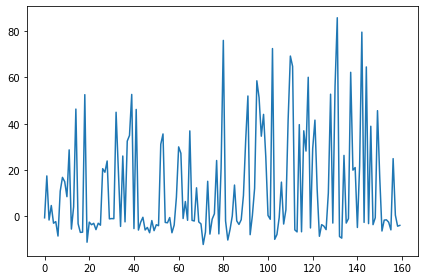

---------- Losses epoch  90 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.33482036 --------
-------- gx_loss:  1.3478069 --------
-------- dm_loss:  0.17874672 --------
-------- gm_loss:  6.446116 --------
---------- ------ ----------
---------- Losses epoch  91 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.2870182 --------
-------- gx_loss:  1.2021972 --------
-------- dm_loss:  0.17504576 --------
-------- gm_loss:  6.6059365 --------
---------- ------ ----------
---------- Losses epoch  92 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.3002547 --------
-------- gx_loss:  1.1283373 --------
-------- dm_loss:  0.17669684 --------
-------- gm_loss:  6.536398 --------
---------- ------ ----------
---------- Losses epoch  93 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.31727728 --------
-------- gx_loss:  1.0981201 --------
-------- dm_loss:  0.175742 ------

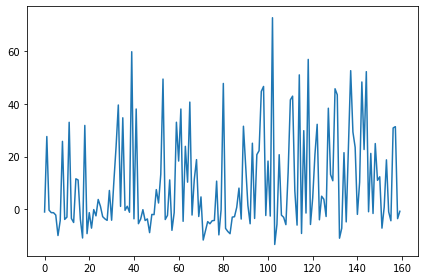

---------- Losses epoch  100 ----------
---------- Metrics names:  ['loss'] ----------
-------- dx_loss:  0.2927777 --------
-------- gx_loss:  0.39826044 --------
-------- dm_loss:  0.17506619 --------
-------- gm_loss:  6.3686705 --------
---------- ------ ----------


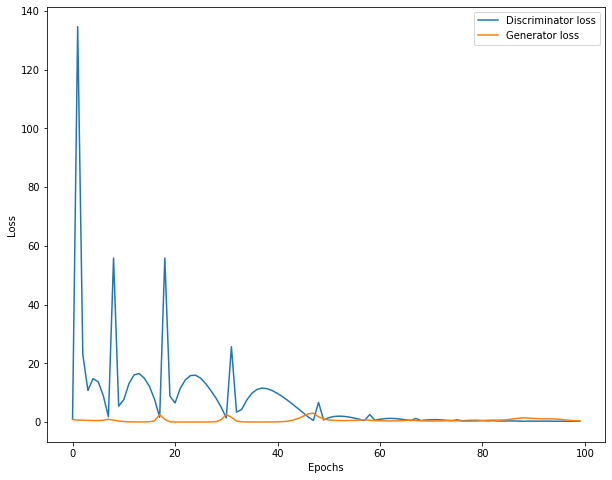

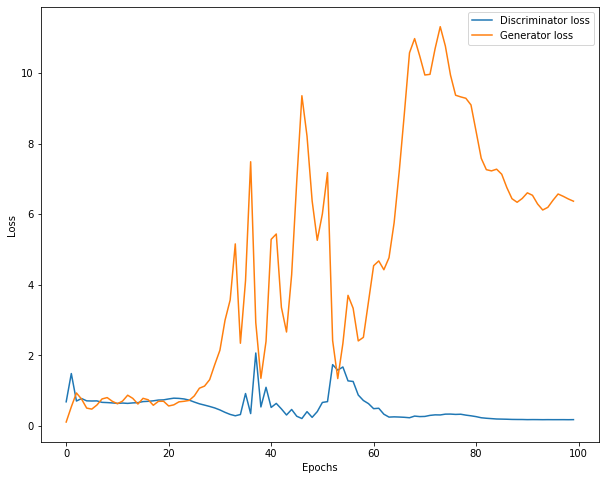

In [0]:
X_train = np.vstack((dados_pressao, dados_completos_aumentados))
X_Masks = get_masks(X_train)
# Removendo os nans e normalizando os dados
X_train = np.nan_to_num(X_train)

output_dimension = n
gx_noise_dimension = n
gm_noise_dimension = n

gx, dx, ganX = build_gan_data(gx_noise_dimension, output_dimension)
gm, dm, ganM = build_gan_mask(gm_noise_dimension, output_dimension)

train_misgan_generation(X_train, X_Masks, gx, dx, ganX, gm, dm, ganM, epochs=100, plt_frq=10, BATCH_SIZE=len(X_train))

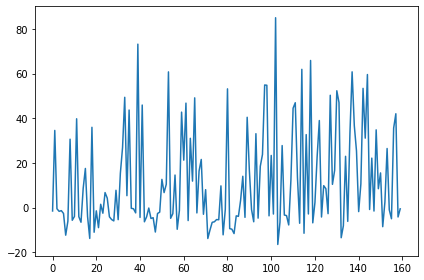

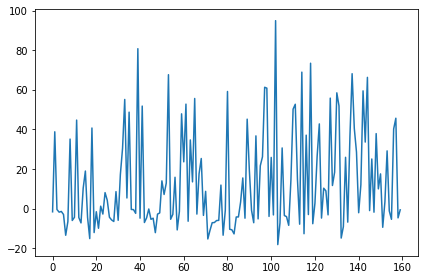

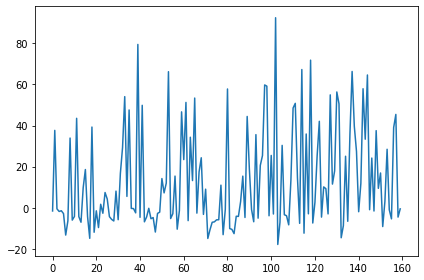

In [0]:
plot_generated_pressures(gx, 3, gx_noise_dimension)

#### 5. Imputando dados através da MisGAN:

Funções para construi os modelos para os imputadores de dados através da MisGAN.

In [0]:
def build_imputation_generator(input_dimension, output_dimension, use_dropout = False, dropout_rate = 0.3):
    gi = Sequential()
    gi.add(Dense(160, input_dim=input_dimension, activation='linear'))
    gi.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        gi.add(Dropout(dropout_rate))
    gi.add(Dense(320, activation='linear'))
    gi.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        gi.add(Dropout(dropout_rate))
    gi.add(Dense(640, activation='linear'))
    gi.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        gi.add(Dropout(dropout_rate))
    gi.add(Dense(1280, activation='linear'))
    gi.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        gi.add(Dropout(dropout_rate))
    gi.add(Dense(output_dimension, activation='linear'))
    gi.add(LeakyReLU(alpha=0.2))
    gi.compile(loss='binary_crossentropy', optimizer='adam')
    return gi

In [0]:
def build_imputation_discriminator(input_dimension, use_dropout = False, dropout_rate = 0.3):
    di = Sequential()
    di.add(Dense(960, input_dim=input_dimension, activation='linear'))
    di.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        di.add(Dropout(dropout_rate))
    di.add(Dense(640, activation='linear'))
    di.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        di.add(Dropout(dropout_rate))
    di.add(Dense(320, activation='linear'))
    di.add(LeakyReLU(alpha=0.2))
    if(use_dropout):
        di.add(Dropout(dropout_rate))
    di.add(Dense(160, activation='linear'))
    di.add(LeakyReLU(alpha=0.2))
    di.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
    di.compile(loss='binary_crossentropy', optimizer='adam')
    return di

Funções auxiliares para o imputador.

In [0]:
def impute_data(data, mask, data_to_impute):
    complement_mask = (1 - mask)
    return data * mask + data_to_impute * complement_mask

In [0]:
def imputation_layer_lambda(tensors):
    real_data = tensors[0]
    generated_data = tensors[1]
    mask = tf.where(real_data != 0, 1.0, 0.0)
    return impute_data(real_data, mask, generated_data)
    

In [0]:
def build_gan_imputation(noise_dimension, output_dimension, use_dropout = False, dropout_rate = 0.3):
    gi = build_imputation_generator(noise_dimension, output_dimension, use_dropout, dropout_rate)
    di = build_imputation_discriminator(output_dimension, use_dropout, dropout_rate)
    di.trainable = False
    inputGi = Input(shape=(noise_dimension,))
    outputGi = gi(inputGi)
    inputDi = Lambda(imputation_layer_lambda, [output_dimension])([inputGi, outputGi])
    outputDi = di(inputDi)
    ganI = Model(inputGi, outputDi)
    ganI.compile(loss='binary_crossentropy', optimizer='adam')
    return gi, di, ganI

In [0]:
def print_summary(epochs, BATCH_SIZE, batchCount, gi, di, ganI):
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    print('-'*10, '-'*5, '-'*10)
    print('-'*10, "Imputation generator", '-'*10)
    gi.summary()
    print('-'*10, "Imputation discriminator", '-'*10)
    di.summary()
    print('-'*10, "Imputation GAN", '-'*10)
    ganI.summary()
    print('-'*10, '-'*5, '-'*10)

In [0]:
def build_generator_input(data, masks):
    size, noise_dimension = np.shape(data)
    return impute_data(data, masks, np.zeros((size, noise_dimension)))

In [0]:
def generate_complemented_data(generator, data, masks):
    generator_input = build_generator_input(data, masks)
    return impute_data(data, masks, generator.predict(generator_input))

Funções para plotar os exames com dados faltantes e com dados imputados.

In [0]:
def plot_pressures_with_missing(pressures, masks):
    for pressure, mask in zip(pressures, masks):
        plt.plot(range(len(pressure)), pressure, color='blue')
        mask_missings = np.where(mask == 0)[0]
        plt.scatter(mask_missings, pressure[mask_missings], marker='x', color='red')
        plt.tight_layout()
        plt.show()

In [0]:
def plot_imputed_pressures(generator, data, masks, sample_size):
    _, noise_dimension = np.shape(data)
    samples_indexes = np.random.randint(0, len(data), size=sample_size)
    imputed_samples = generate_complemented_data(generator, data[samples_indexes], masks[samples_indexes])
    plot_pressures_with_missing(imputed_samples, masks[samples_indexes])
    return imputed_samples

Funções auxiliares para o funcionamento do imputador.

In [0]:
def build_discriminator_batch_input(data, masks, gi, gx, X_reference):
    size, noise_dimension = np.shape(data)
#     gx_generated = gx.predict(generate_noise(size, noise_dimension))
    gx_generated = X_reference[np.random.randint(0, len(X_reference), size)]
    gi_generated = gi.predict(data)
    return np.vstack((gx_generated, gi_generated))

In [0]:
def train_generator(gan, data, masks):
    size, noise_dimension = np.shape(data)
    generator_input = build_generator_input(data, masks)
    return gan.train_on_batch(generator_input, np.ones(size))

Função para fazer o treino efetivamente do imputador com a MisGAN.

In [0]:
def train_misgan_imputation(X_train, X_reference, X_Masks, gx, gi, di, ganI, epochs=1000, plt_frq=100, BATCH_SIZE=128):
    # Set up a vector (dict) to store the losses
    losses = {"D":[], "G":[]}

    m, n = np.shape(X_train)
    batchCount = int(m / BATCH_SIZE)
    print_summary(epochs, BATCH_SIZE, batchCount, gi, di, ganI)

    for e in range(1, epochs+1):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
            plot_imputed_pressures(gi, X_train, X_Masks, 1)
        for _ in range(batchCount):
            # Create a batch by drawing random index numbers from the training set
            batch_indexes = np.random.randint(0, m, size=BATCH_SIZE)

            # Build discriminators inputs
            di_inputs = build_discriminator_batch_input(X_train[batch_indexes], X_Masks[batch_indexes], gi, gx, X_reference)

            # Build batch labels
            y = build_discriminator_labels(BATCH_SIZE, label_smothing_coef=1)

            # Train discriminator on generated output
            di_loss = train_discriminator(di, di_inputs, y)

            # Train data generator
            gi_loss = train_generator(ganI, X_train[batch_indexes], X_Masks[batch_indexes])
        print('-'*10, "Losses epoch ", e, '-'*10)
        print('-'*10, 'D Metrics names: ', di.metrics_names, '-'*10)
        print('-'*8, "d_loss: ", di_loss , '-'*8)
        print('-'*10, 'G Metrics names: ', gi.metrics_names, '-'*10)
        print('-'*8, "g_loss: ", gi_loss , '-'*8)
        print('-'*10, "------" , '-'*10)
        # Only store losses from final batch of epoch
        losses["D"].append(di_loss)
        losses["G"].append(gi_loss)
    plot_loss(losses)

In [0]:
def generateIncompleteDataFromComplete(complete_data, num_missing):
    _, data_size = np.shape(complete_data)
    generated_incomplete_data = np.zeros(data_size)
    generated_masks = np.zeros(data_size)
    for entry in complete_data:
        mask = np.ones(data_size)
        mask[:num_missing] = 0
        np.random.shuffle(mask)
        generated_incomplete_data = np.vstack((generated_incomplete_data, entry * mask))
        generated_masks = np.vstack((generated_masks, mask))
    return generated_incomplete_data[1:], generated_masks[1:]

In [0]:
X_train = np.nan_to_num(dados_pressao_incompletos)
X_Masks = get_masks(dados_pressao_incompletos)

m, n = np.shape(X_train)
output_dimension = n
gi_noise_dimension = n

X_reference = np.vstack((dados_pressao_completos, dados_completos_aumentados))

In [0]:
num_missings = [int(0.2*output_dimension)]
for total_missing in num_missings:
    generated_incomplete_data, generated_masks = generateIncompleteDataFromComplete(X_reference, total_missing)
    X_train = np.vstack((X_train, generated_incomplete_data))
    X_Masks = np.vstack((X_Masks, generated_masks))

Verificação do funcionamento do imputador.

In [0]:
print('Generated incomplete data: ')
print(X_train[-5:-1])
print('Generated maks: ')
print(X_Masks[-5:-1])

Generated incomplete data: 
[[  0.  110.  114.5   0.  106.  118.5 126.5 128.5 107.5 119.5 109.  122.5
  116.  116.    0.  105.5 116.  130.  141.5   0.  112.5 114.  127.  110.
  120.  121.    0.  117.  115.5 113.5   0.  128.    0.  118.  119.5 118.5
  121.    0.  129.  123.5 124.    0.  125.  118.  115.  117.5 123.  118.5
  123.  120.  109.5 106.  108.5 110.5   0.  107.  102.  109.    0.  110.
  110.  100.5 107.5 101.5 110.5 113.  116.  116.  108.5   0.    0.  123.5
  115.  140.5 141.  133.    0.    0.  117.5 114.   69.5  68.5  75.   78.5
   67.   76.   68.5  81.   73.5  70.   63.    0.    0.   75.5  76.5  70.5
   73.5   0.   72.5  71.5  56.    0.    0.   69.5  66.    0.   72.5  76.
   72.5  71.5  70.    0.   69.5   0.   69.   73.    0.   78.   74.5  75.5
    0.   76.    0.   73.5  61.5  74.5  71.   77.5  69.    0.   66.5  61.
    0.   62.   56.    0.   56.   64.   51.   62.   57.   57.5  64.5   0.
   56.    0.   68.   65.5  66.5  54.   62.5  72.   69.   80.5  80.5  76.5
    0.   67.5  

In [0]:
gi, di, ganI = build_gan_imputation(gi_noise_dimension, output_dimension, False)

Treino efetivo do imputador.

Epochs: 200
Batch size: 128
Batches per epoch: 150
---------- ----- ----------
---------- Imputation generator ----------
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 160)               25760     
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 160)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 320)               51520     
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 320)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 640)               205440    
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 640)               0       

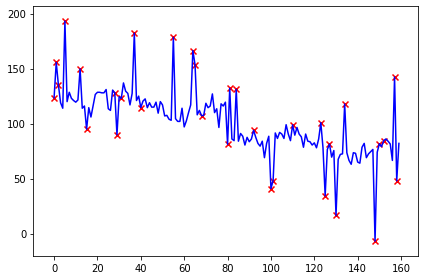

---------- Losses epoch  1 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  9.740035e-05 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  2.7125124e-09 --------
---------- ------ ----------
---------- Losses epoch  2 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.0 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.0 --------
---------- ------ ----------
---------- Losses epoch  3 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.0 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.7878503 --------
---------- ------ ----------
---------- Losses epoch  4 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.67350626 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.0 --------
---------- ------ ----------
---------- Losses epoch  5 ----------
---------- D Metrics n

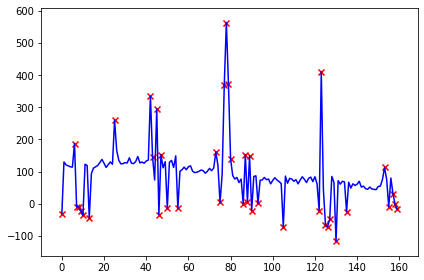

---------- Losses epoch  20 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.0 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.0 --------
---------- ------ ----------
---------- Losses epoch  21 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.0 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.0 --------
---------- ------ ----------
---------- Losses epoch  22 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.0 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.0 --------
---------- ------ ----------
---------- Losses epoch  23 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.0 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.0 --------
---------- ------ ----------
---------- Losses epoch  24 ----------
---------- D Metrics names:  ['loss'] ----------


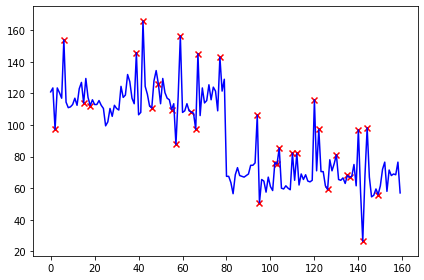

---------- Losses epoch  40 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  8.912557e-24 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.5215673 --------
---------- ------ ----------
---------- Losses epoch  41 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.049712203 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  1.9072304 --------
---------- ------ ----------
---------- Losses epoch  42 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  7.5302377 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  3.3006382 --------
---------- ------ ----------
---------- Losses epoch  43 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  5.780069 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.0 --------
---------- ------ ----------
---------- Losses epoch  44 ----------
---

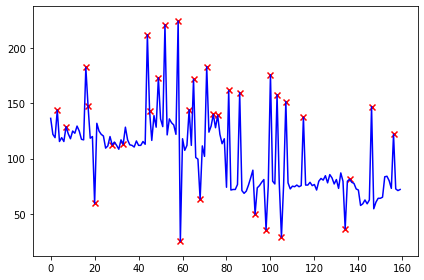

---------- Losses epoch  60 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.09607817 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  5.771061 --------
---------- ------ ----------
---------- Losses epoch  61 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.0 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.0 --------
---------- ------ ----------
---------- Losses epoch  62 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  3.7348213e-10 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  6.661497 --------
---------- ------ ----------
---------- Losses epoch  63 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.0 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.0 --------
---------- ------ ----------
---------- Losses epoch  64 ----------
---------- D Metrics n

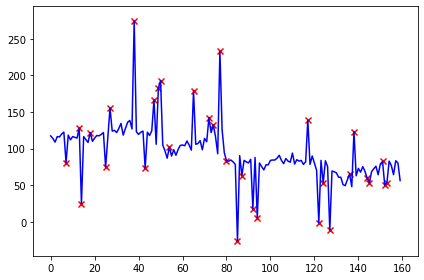

---------- Losses epoch  80 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.51718736 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.3647738 --------
---------- ------ ----------
---------- Losses epoch  81 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.00050926476 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.30305955 --------
---------- ------ ----------
---------- Losses epoch  82 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.7963963 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.11851048 --------
---------- ------ ----------
---------- Losses epoch  83 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  0.30542156 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  0.0013523946 --------
---------- ------ ----------
---------- Losses epoch  84 -

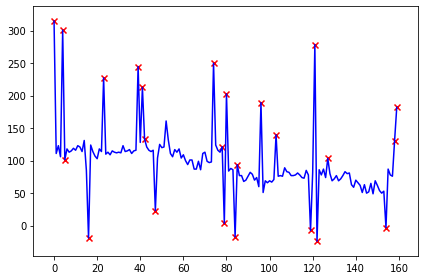

---------- Losses epoch  100 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  1.4145124e-07 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  2.548116 --------
---------- ------ ----------
---------- Losses epoch  101 ----------
---------- D Metrics names:  ['loss'] ----------
-------- d_loss:  3.2156658 --------
---------- G Metrics names:  ['loss'] ----------
-------- g_loss:  5.7389507 --------
---------- ------ ----------


KeyboardInterrupt: 

In [0]:
train_misgan_imputation(X_train, X_reference, X_Masks, g, gi, di, ganI, epochs=200, plt_frq=20, BATCH_SIZE=128)

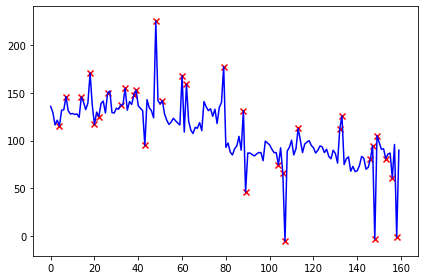

In [0]:
# Teste de imputação
plot_imputed_pressures(gi, X_train, X_Masks, 1)

Definindo uma maneira de avaliar os resultados obtidos.

In [0]:
def error_metric(true_data, predicted, mask):
    true_data = true_data * mask
    predicted = predicted * (1 - mask)
    error_dif = true_data - predicted
    return np.absolute(error_dif).sum()

In [0]:
X_test = np.zeros(output_dimension)
X_test_masks = np.zeros(output_dimension)

num_missings = [5]
for total_missing in num_missings:
    generated_incomplete_data, generated_masks = generateIncompleteDataFromComplete(dados_pressao_completos, total_missing)
    X_test = np.vstack((X_test, generated_incomplete_data))
    X_test_masks = np.vstack((X_test_masks, generated_masks))
    
X_test = X_test[1:]
X_test_masks = X_test_masks[1:]

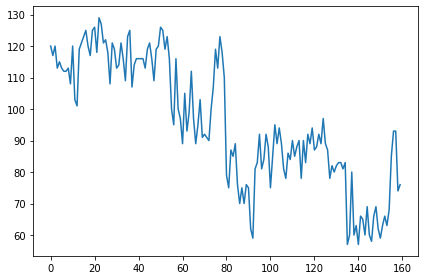

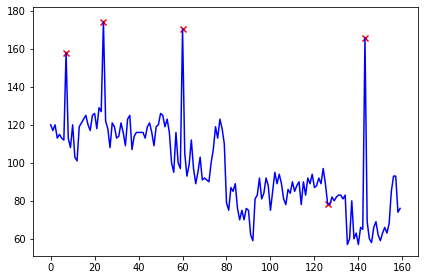

Test data index:  0  Error:  15567.277503967285


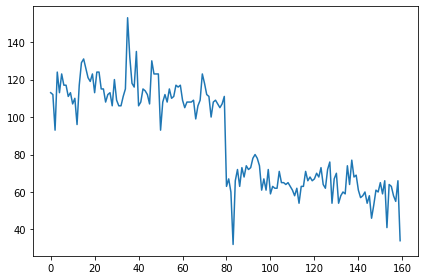

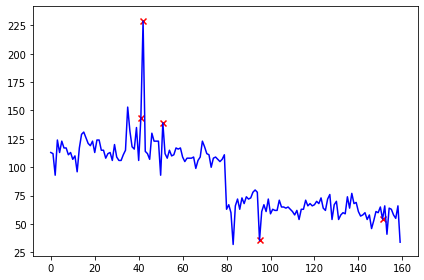

Test data index:  1  Error:  14333.415218353271


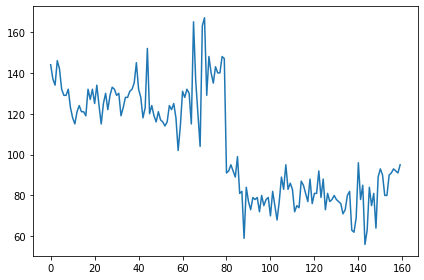

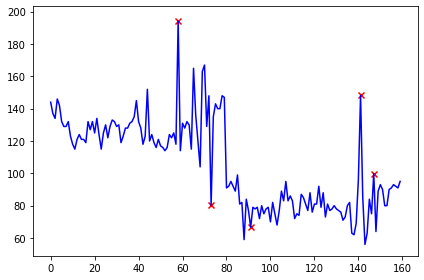

Test data index:  2  Error:  16891.043281555176


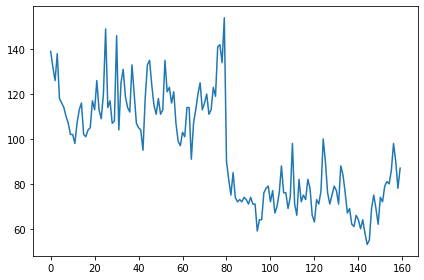

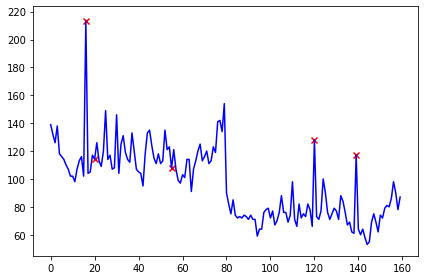

Test data index:  3  Error:  15485.386215209961


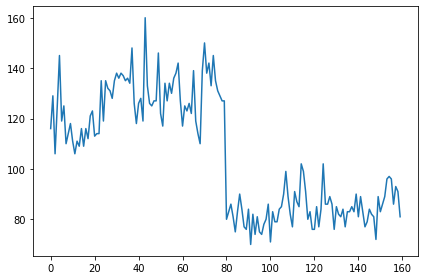

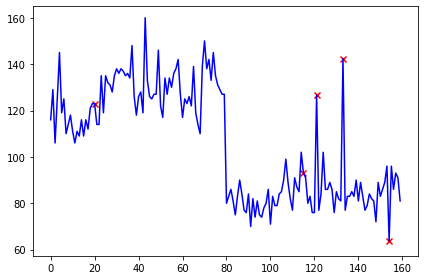

Test data index:  4  Error:  16934.658367156982


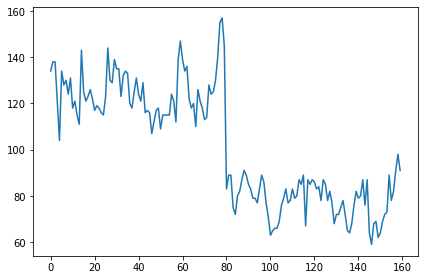

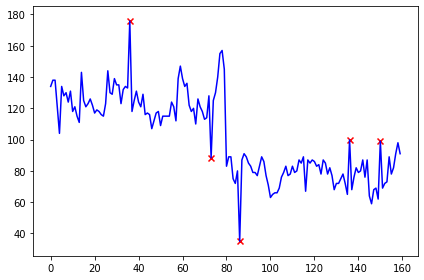

Test data index:  5  Error:  16318.008247375488


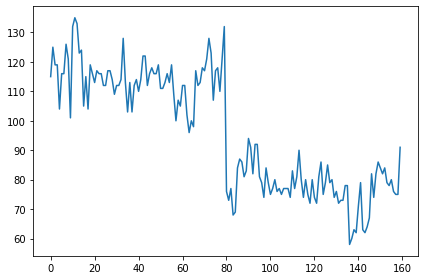

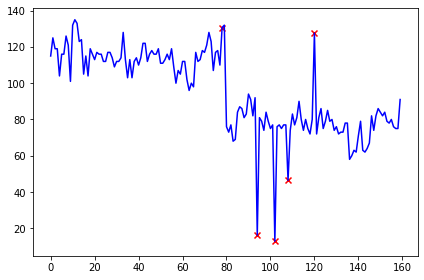

Test data index:  6  Error:  15268.839341163635


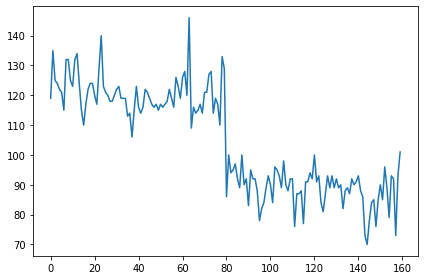

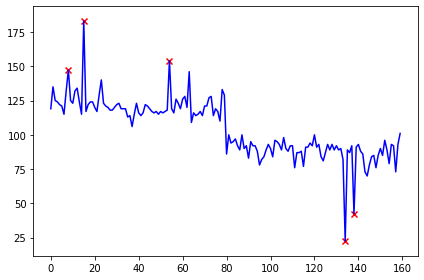

Test data index:  7  Error:  16771.102937698364


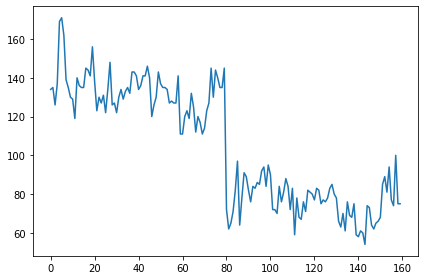

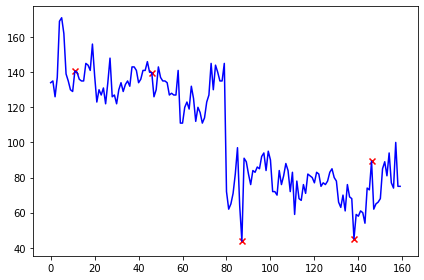

Test data index:  8  Error:  16757.64426803589


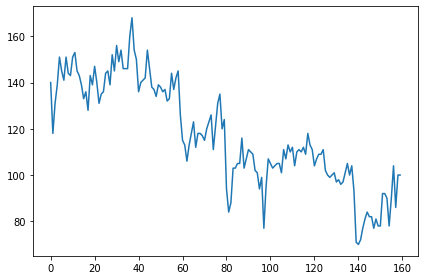

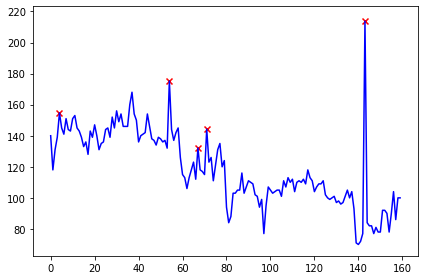

Test data index:  9  Error:  19014.009826660156


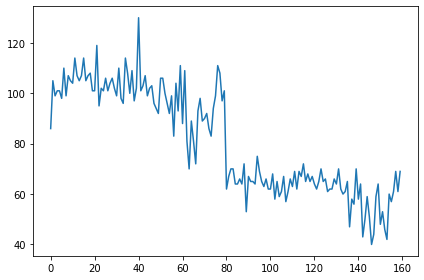

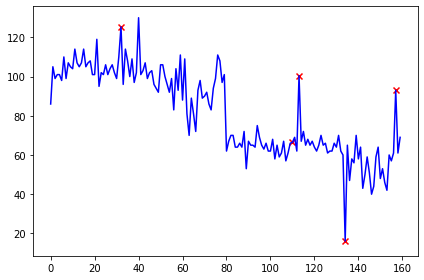

Test data index:  10  Error:  13000.34990310669


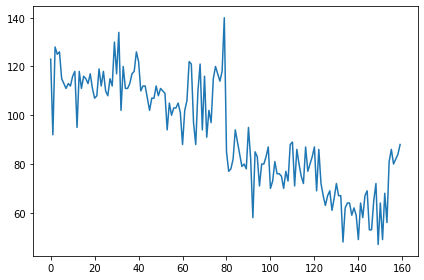

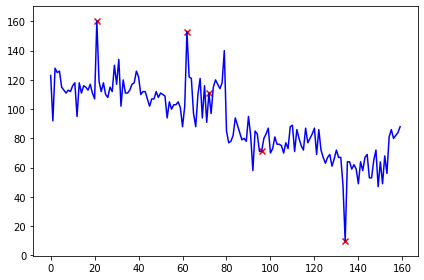

Test data index:  11  Error:  14817.329691886902


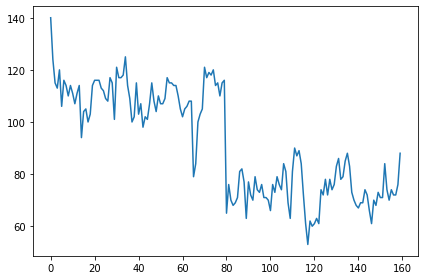

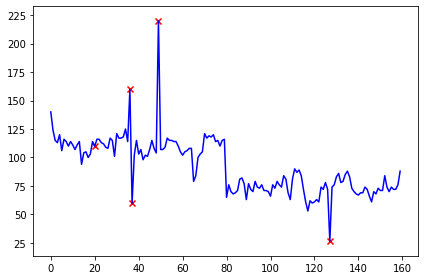

Test data index:  12  Error:  14770.012893676758


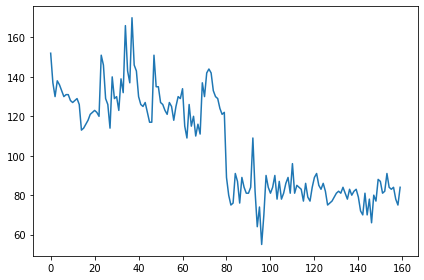

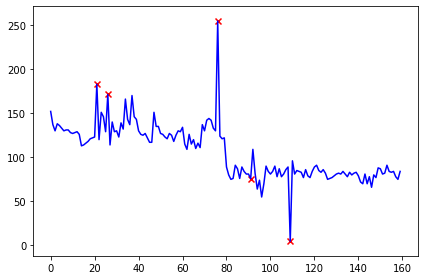

Test data index:  13  Error:  16998.236055374146


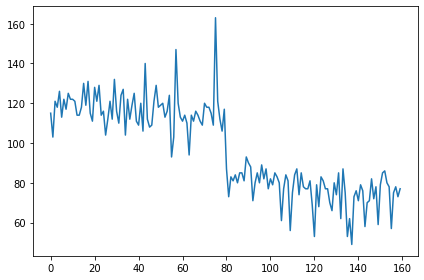

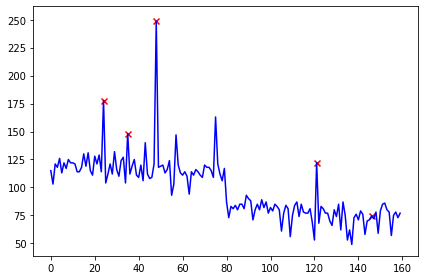

Test data index:  14  Error:  15752.106834411621


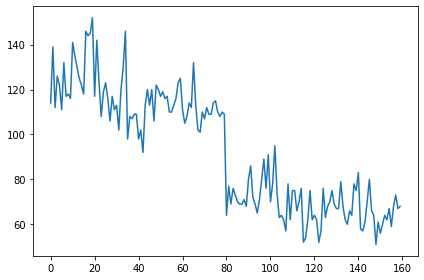

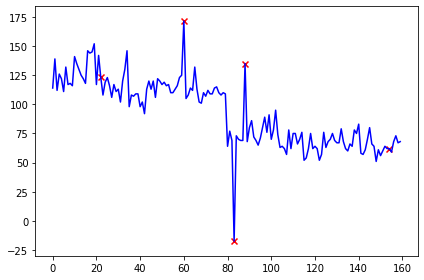

Test data index:  15  Error:  14924.999767303467


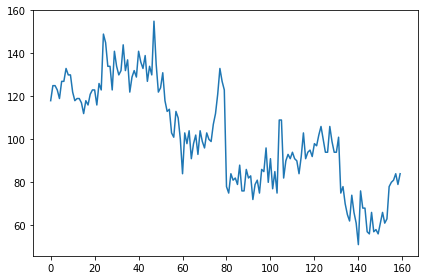

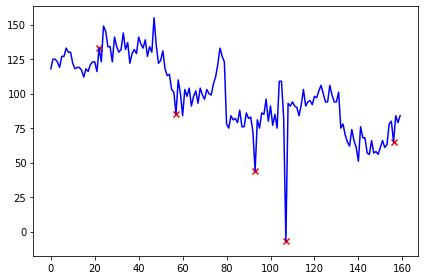

Test data index:  16  Error:  16036.531368255615


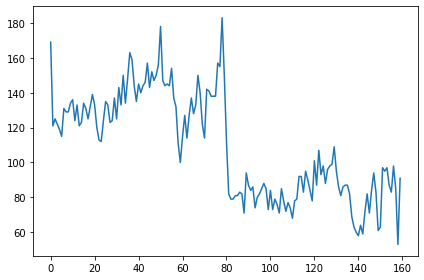

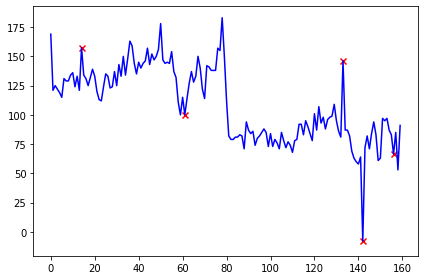

Test data index:  17  Error:  17510.861944675446


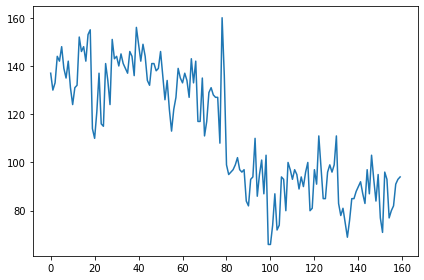

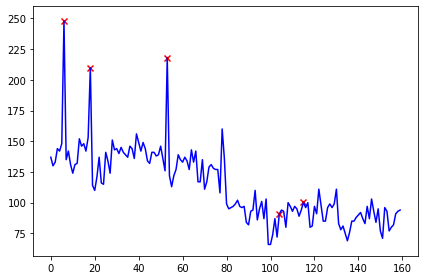

Test data index:  18  Error:  18257.48706817627


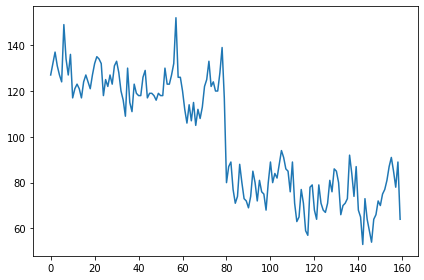

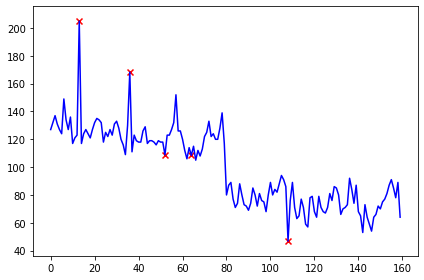

Test data index:  19  Error:  16007.29040145874


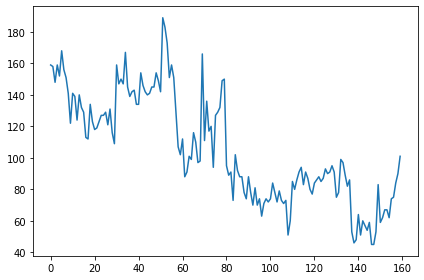

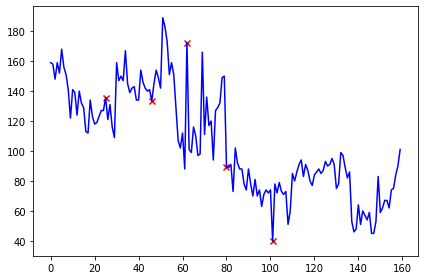

Test data index:  20  Error:  16934.969902038574


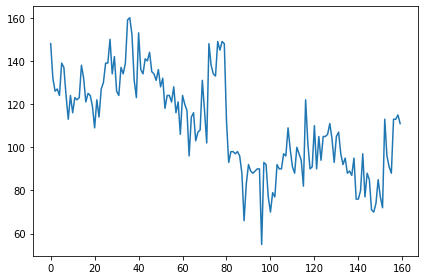

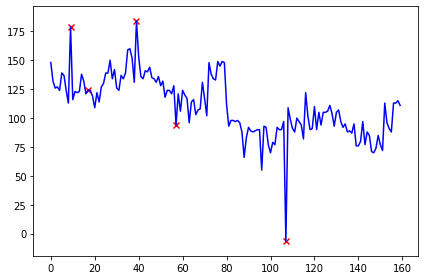

Test data index:  21  Error:  17718.42257452011


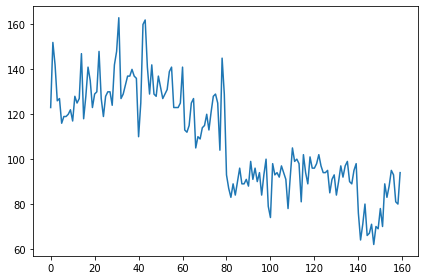

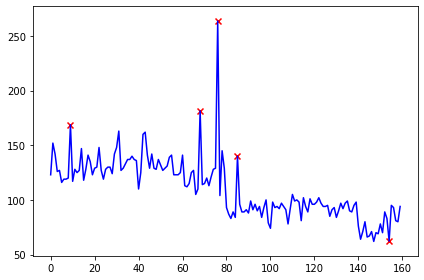

Test data index:  22  Error:  17683.091957092285


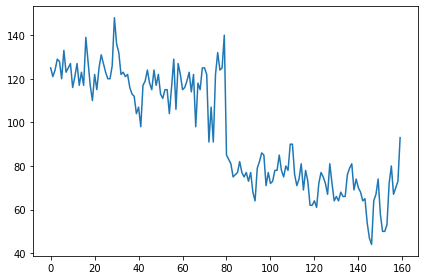

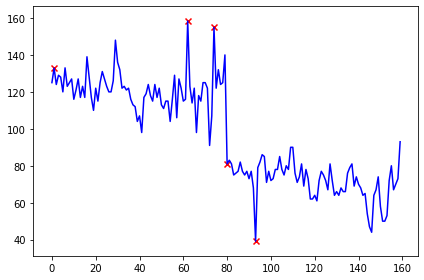

Test data index:  23  Error:  15447.38349533081


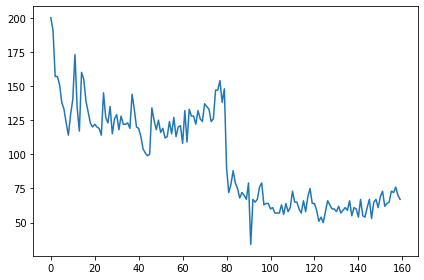

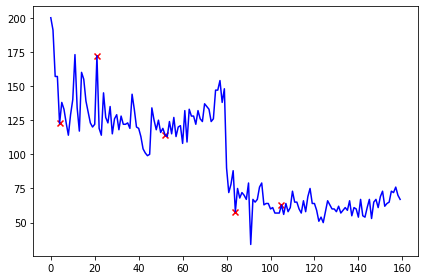

Test data index:  24  Error:  15484.03182220459


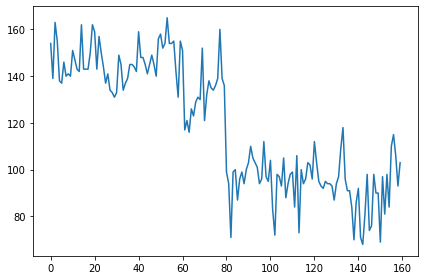

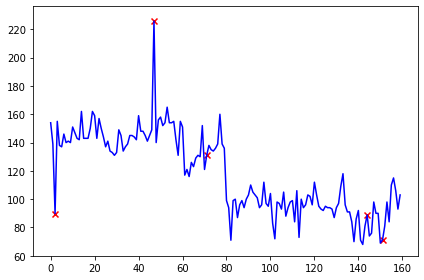

Test data index:  25  Error:  18942.85996246338


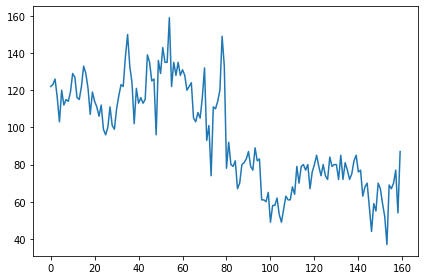

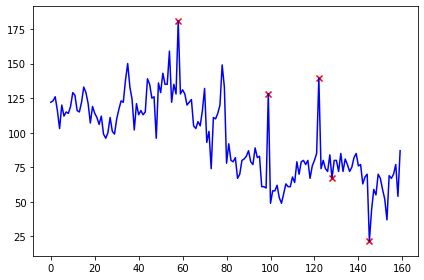

Test data index:  26  Error:  15353.229217529297


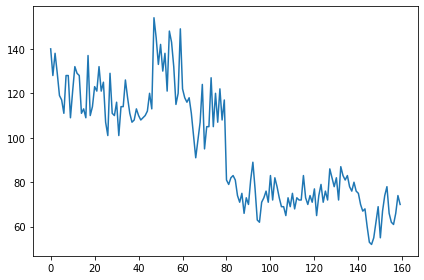

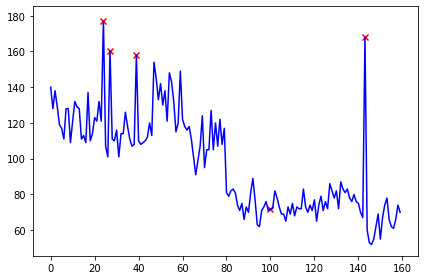

Test data index:  27  Error:  15570.2310256958


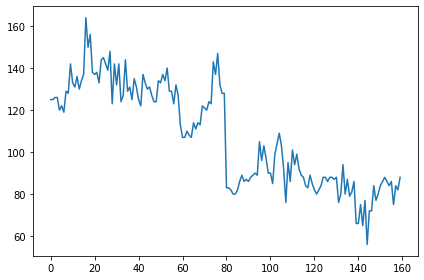

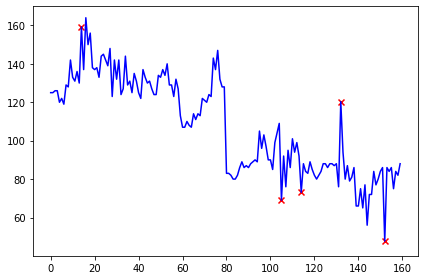

Test data index:  28  Error:  17208.471168518066


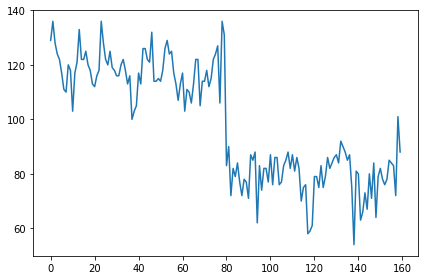

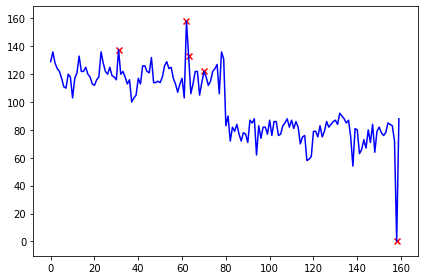

Test data index:  29  Error:  15795.95050418377


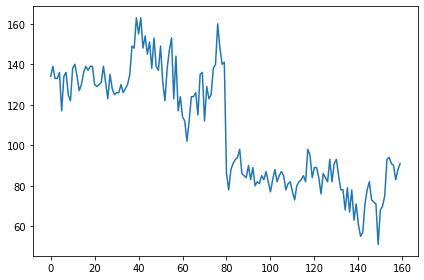

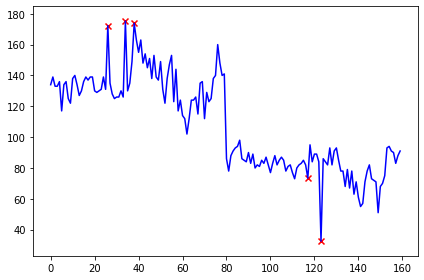

Test data index:  30  Error:  17293.393520355225


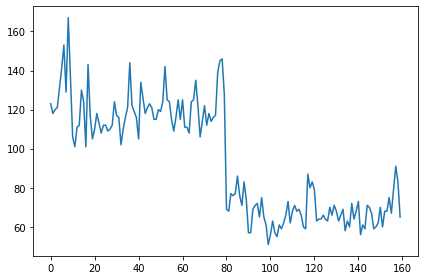

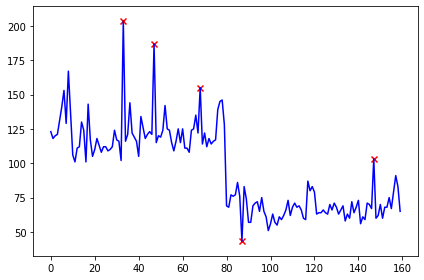

Test data index:  31  Error:  15290.615009307861


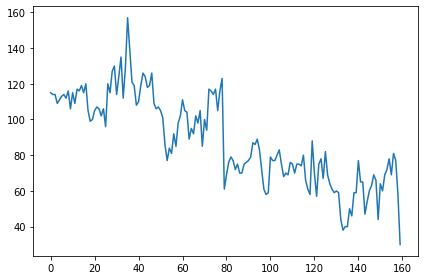

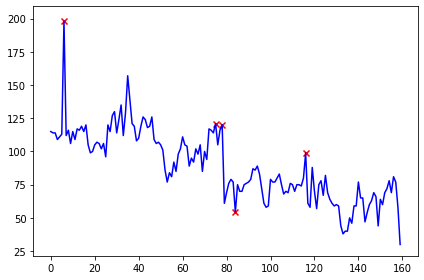

Test data index:  32  Error:  14246.468475341797


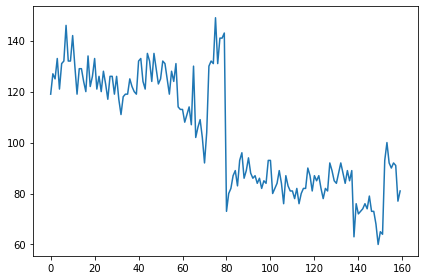

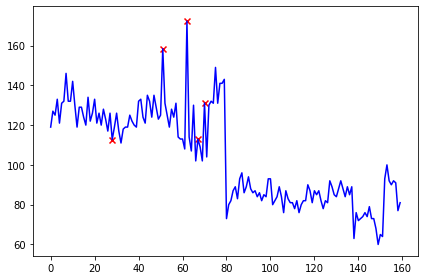

Test data index:  33  Error:  16692.305778503418


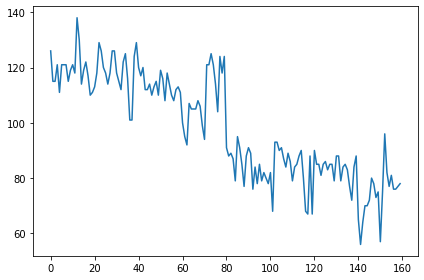

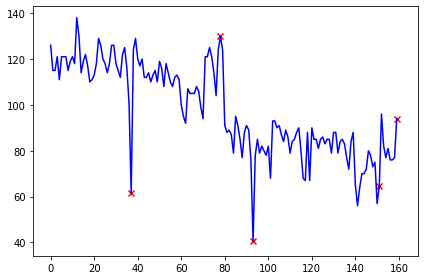

Test data index:  34  Error:  15651.592601776123


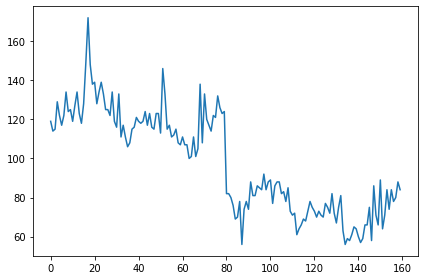

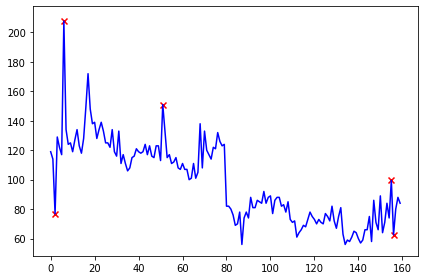

Test data index:  35  Error:  15734.652408599854


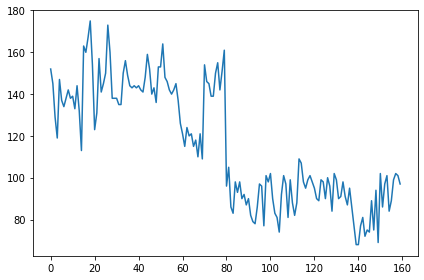

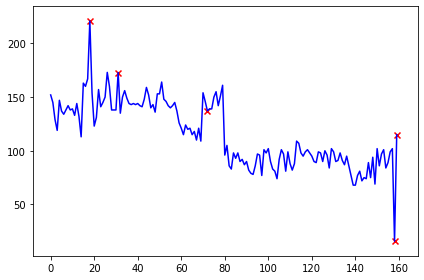

Test data index:  36  Error:  18553.8075466156


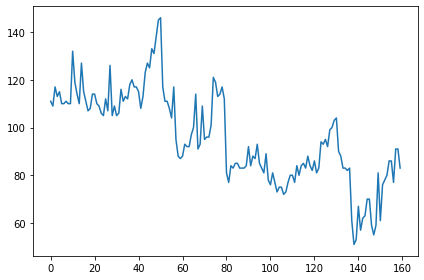

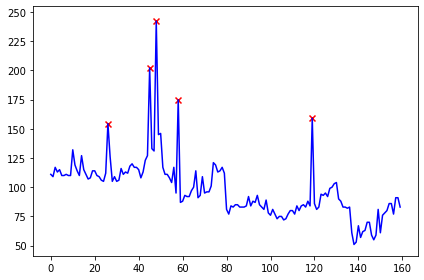

Test data index:  37  Error:  15728.163192749023


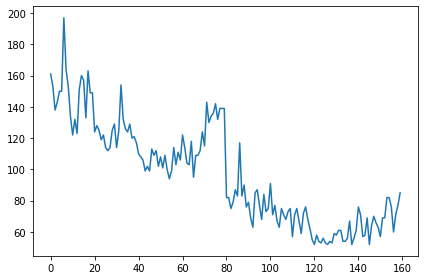

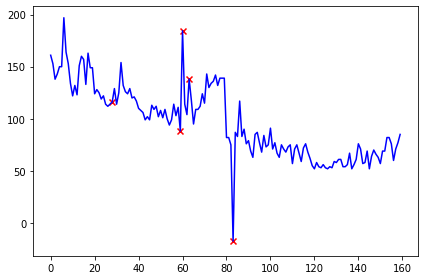

Test data index:  38  Error:  15534.435009002686


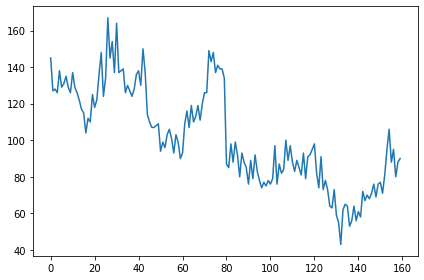

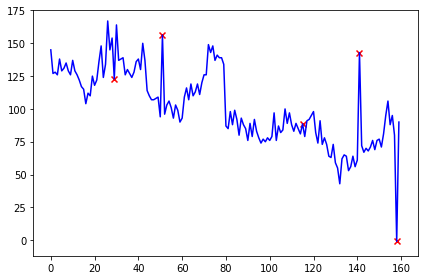

Test data index:  39  Error:  16318.514143943787


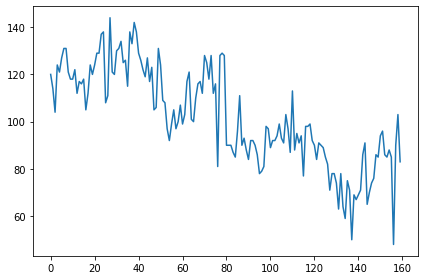

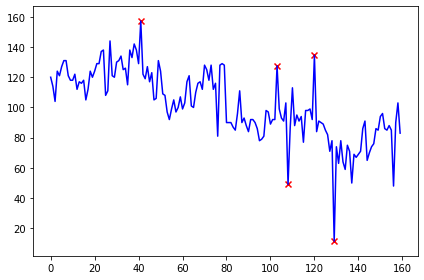

Test data index:  40  Error:  16292.867221832275


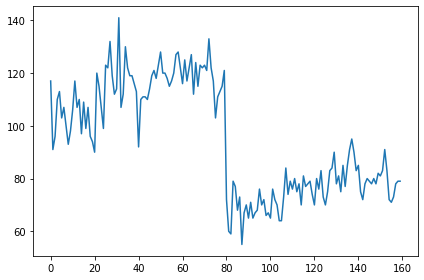

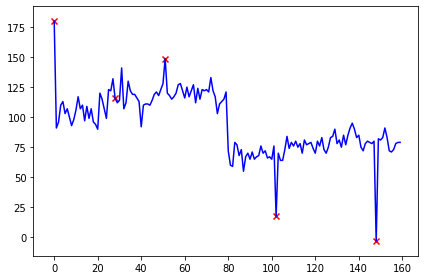

Test data index:  41  Error:  15144.197123289108


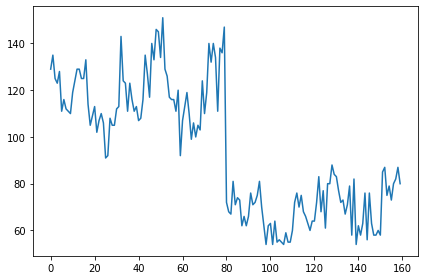

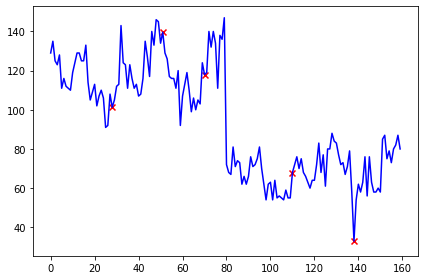

Test data index:  42  Error:  14988.807674407959


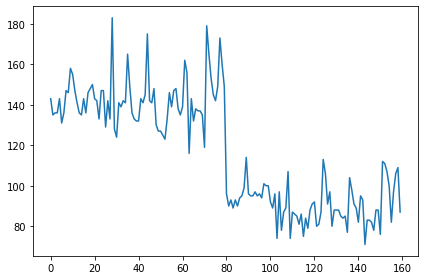

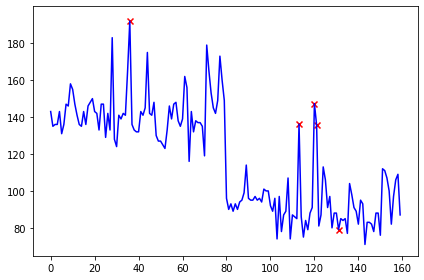

Test data index:  43  Error:  18872.30827331543


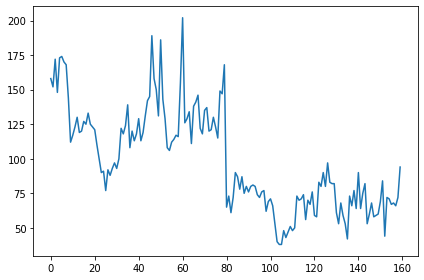

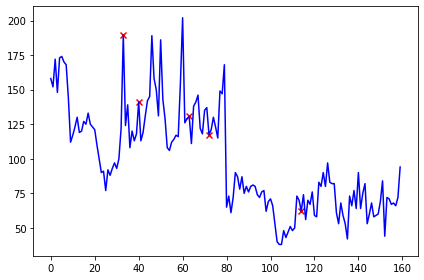

Test data index:  44  Error:  15851.766376495361


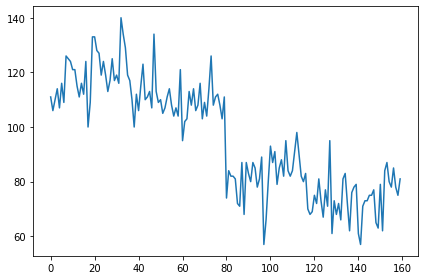

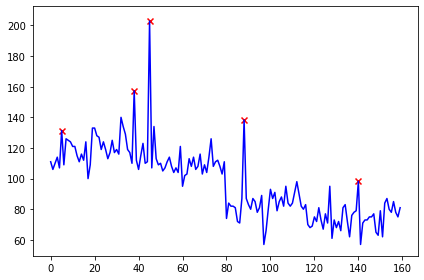

Test data index:  45  Error:  15620.080955505371


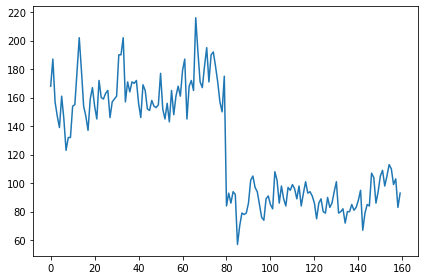

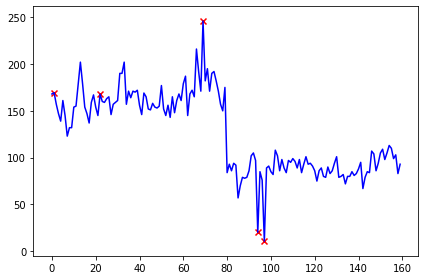

Test data index:  46  Error:  20186.105275154114


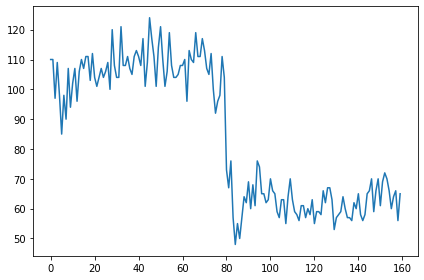

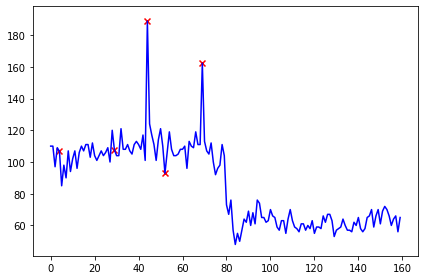

Test data index:  47  Error:  13665.40950012207


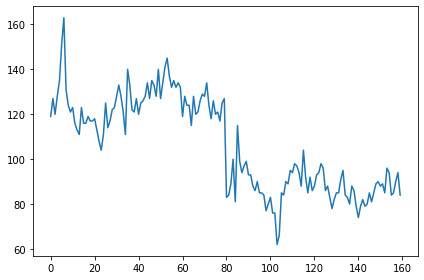

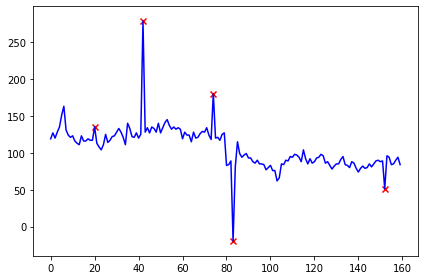

Test data index:  48  Error:  17130.66453933716


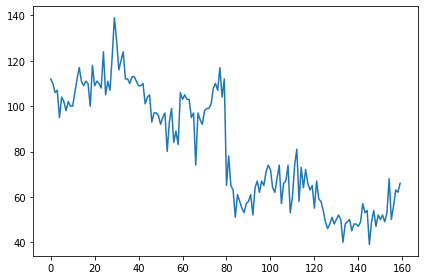

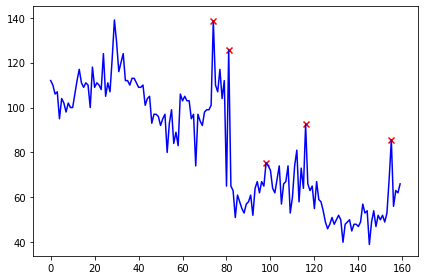

Test data index:  49  Error:  13196.38452911377


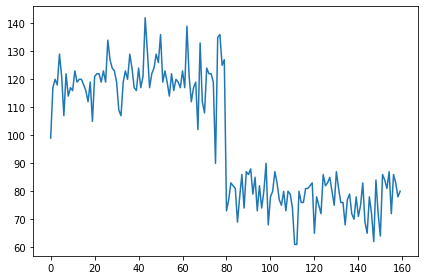

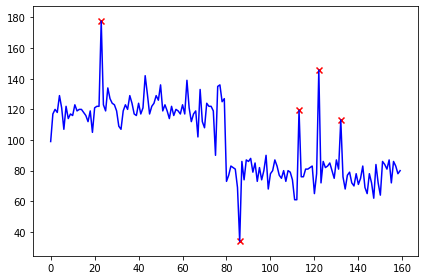

Test data index:  50  Error:  15989.74647140503


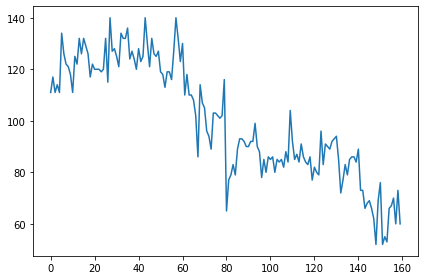

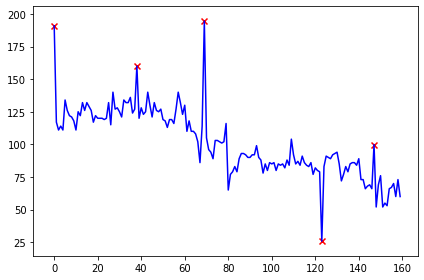

Test data index:  51  Error:  16186.035219192505


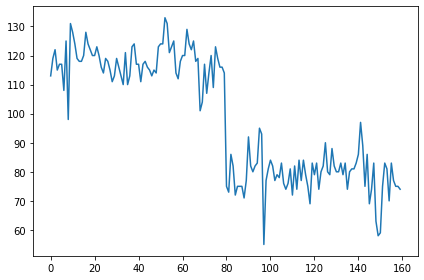

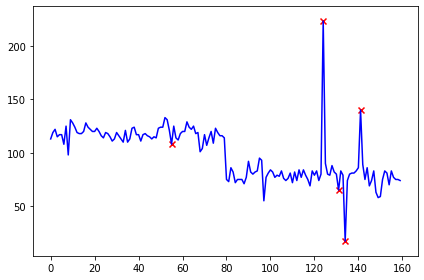

Test data index:  52  Error:  15833.915594100952


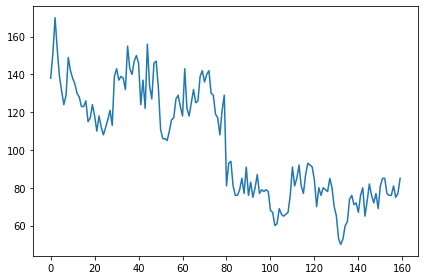

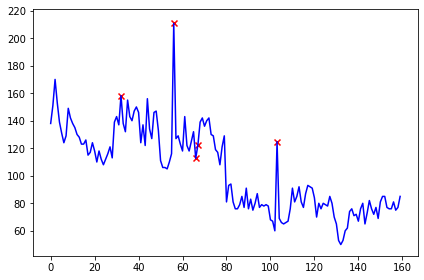

Test data index:  53  Error:  16632.907180786133


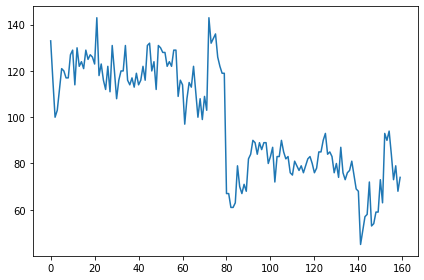

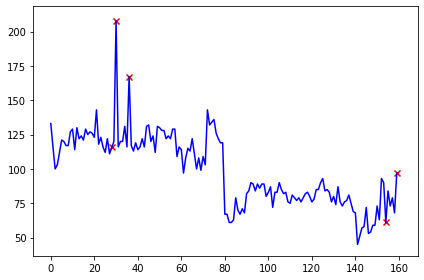

Test data index:  54  Error:  15839.28674697876


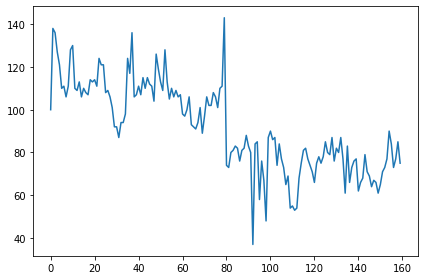

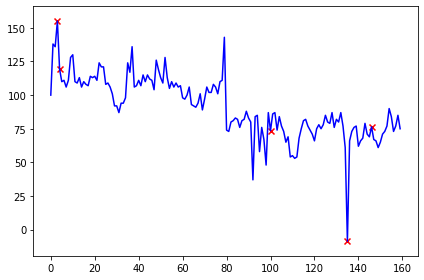

Test data index:  55  Error:  14638.995425224304


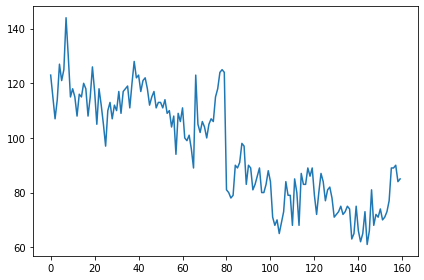

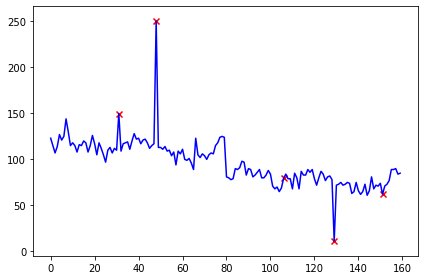

Test data index:  56  Error:  15434.931650161743


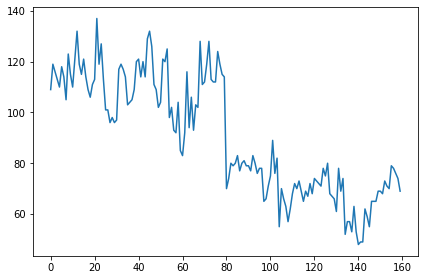

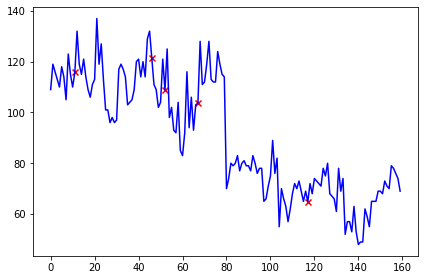

Test data index:  57  Error:  14480.537559509277


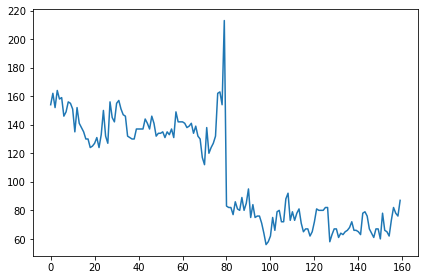

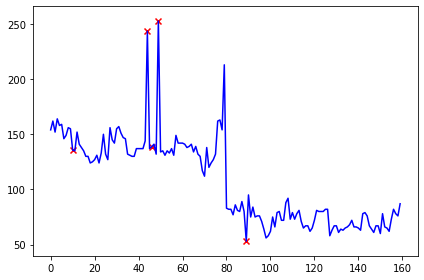

Test data index:  58  Error:  17257.755825042725


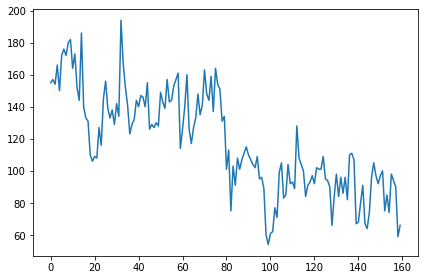

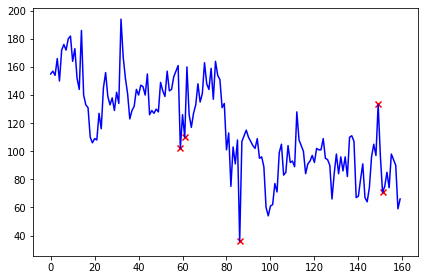

Test data index:  59  Error:  18751.862747192383


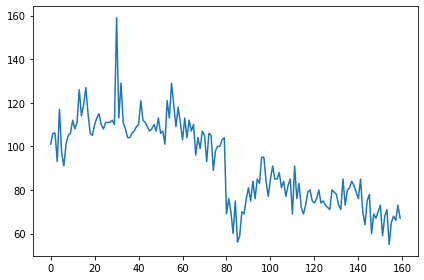

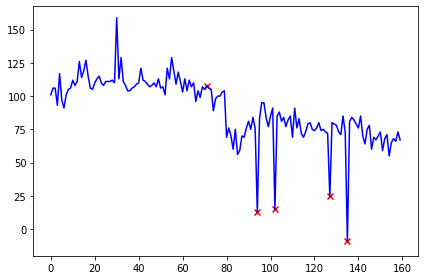

Test data index:  60  Error:  14525.879660606384


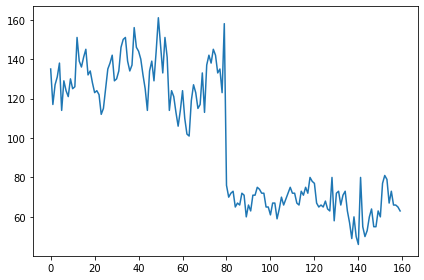

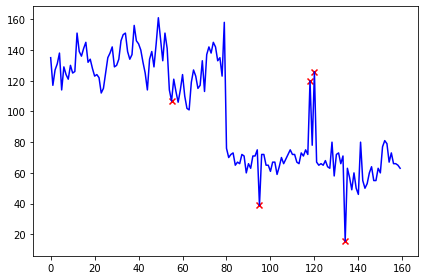

Test data index:  61  Error:  15819.975690841675


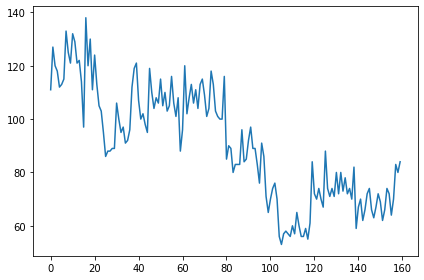

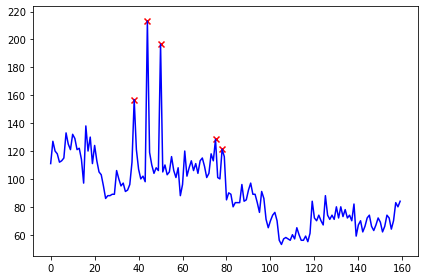

Test data index:  62  Error:  14772.3042678833


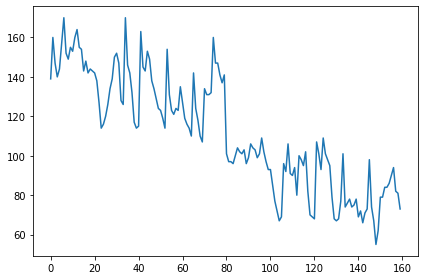

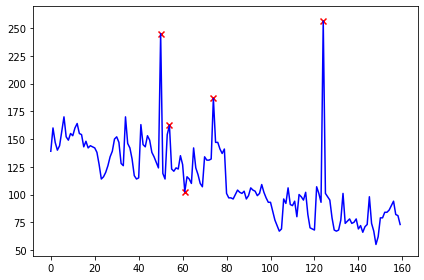

Test data index:  63  Error:  18221.732383728027


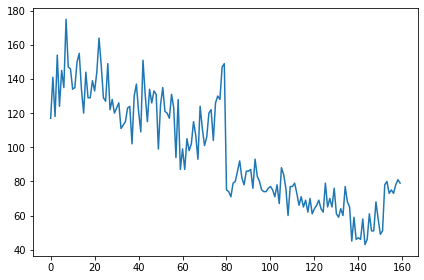

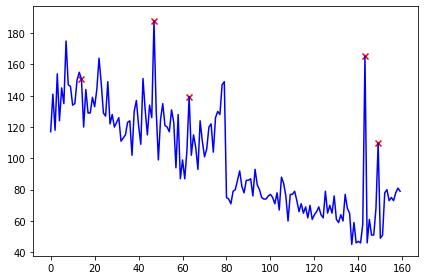

Test data index:  64  Error:  15913.742660522461


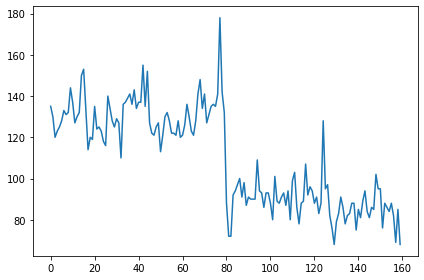

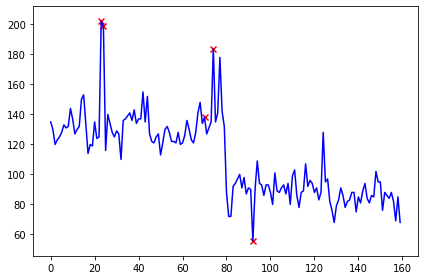

Test data index:  65  Error:  17742.641998291016


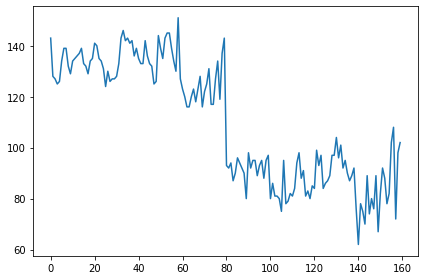

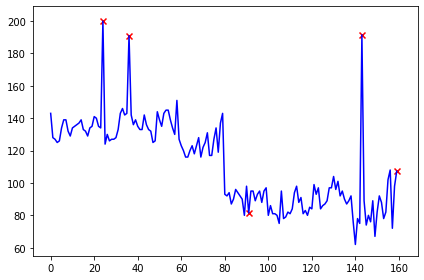

Test data index:  66  Error:  17837.180381774902


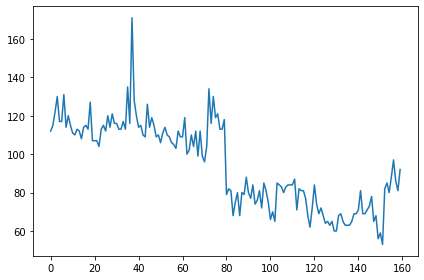

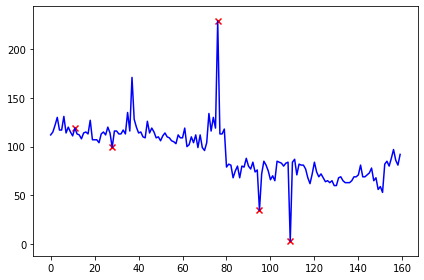

Test data index:  67  Error:  15073.757784843445


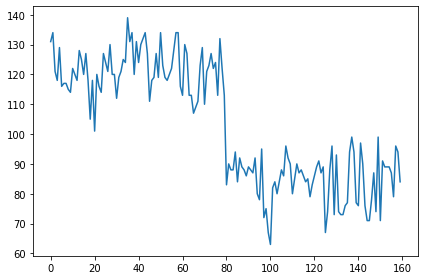

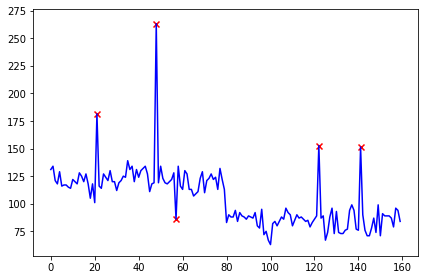

Test data index:  68  Error:  16753.72324371338


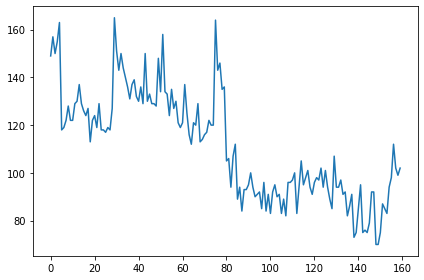

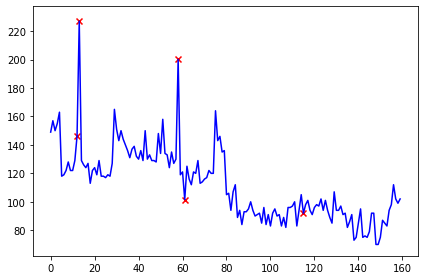

Test data index:  69  Error:  17963.94059753418


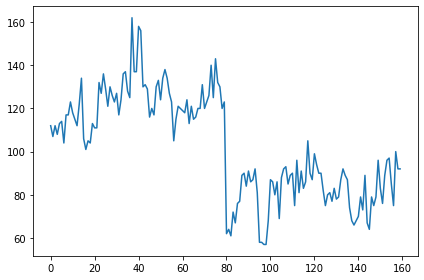

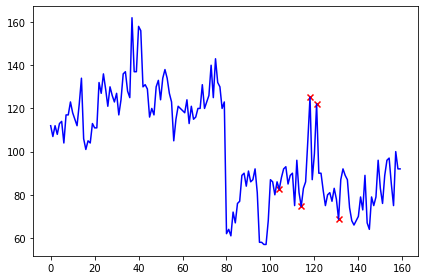

Test data index:  70  Error:  16434.115058898926


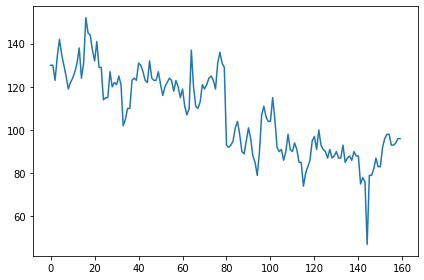

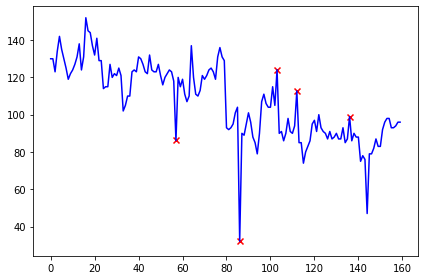

Test data index:  71  Error:  17145.16947555542


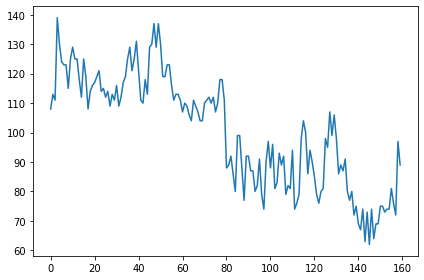

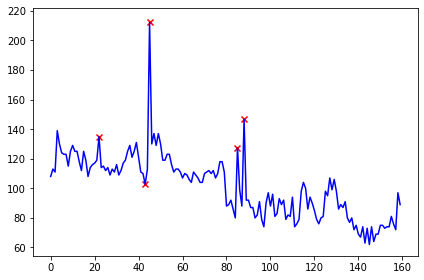

Test data index:  72  Error:  16252.757339477539


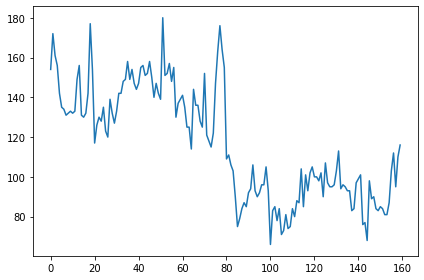

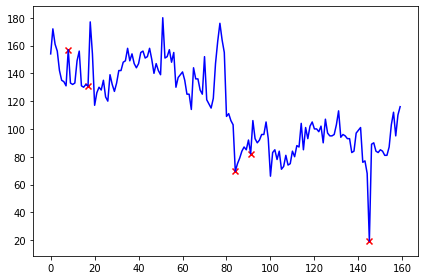

Test data index:  73  Error:  18594.92544746399


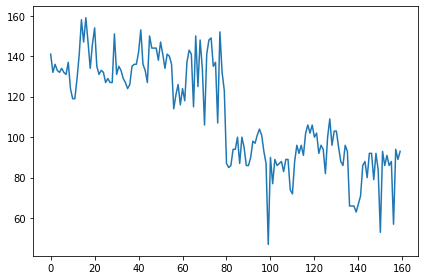

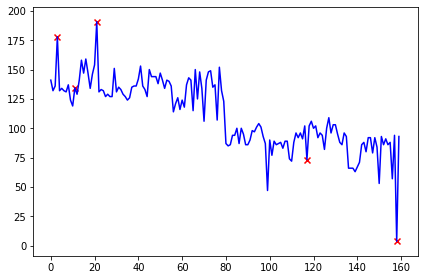

Test data index:  74  Error:  17857.393352985382


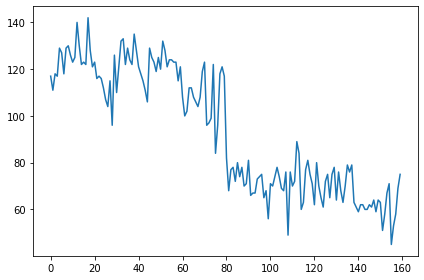

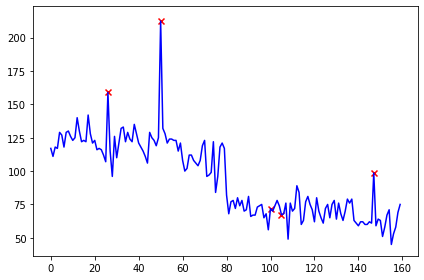

Test data index:  75  Error:  15156.034545898438


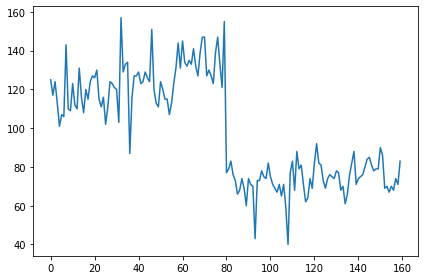

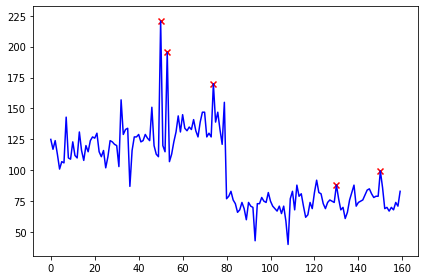

Test data index:  76  Error:  16079.638374328613


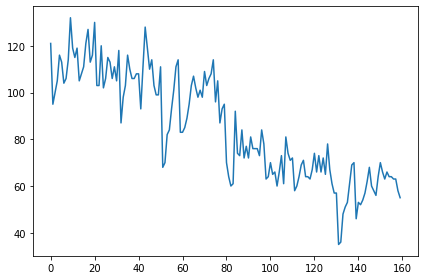

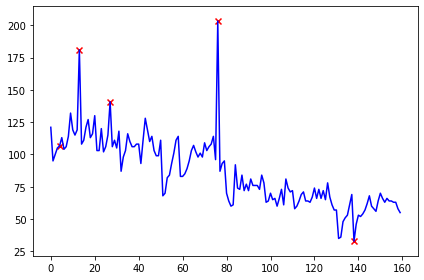

Test data index:  77  Error:  13789.308986663818


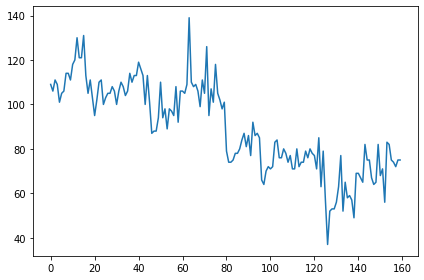

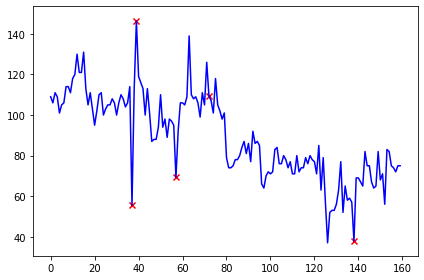

Test data index:  78  Error:  14272.48335647583


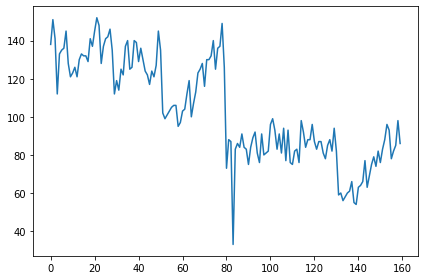

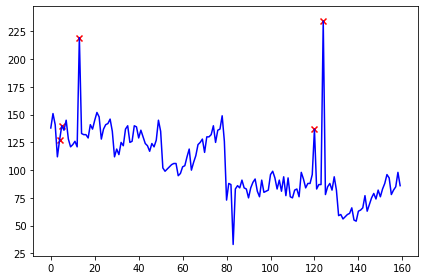

Test data index:  79  Error:  16795.790496826172


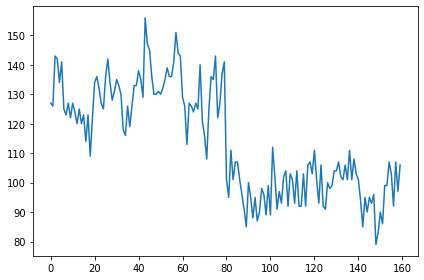

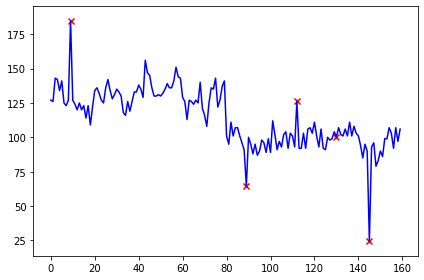

Test data index:  80  Error:  18259.377492904663


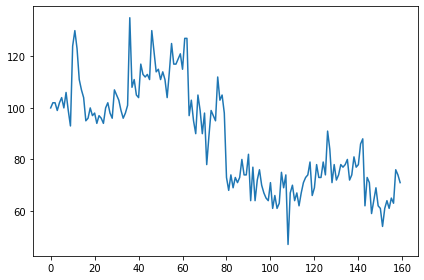

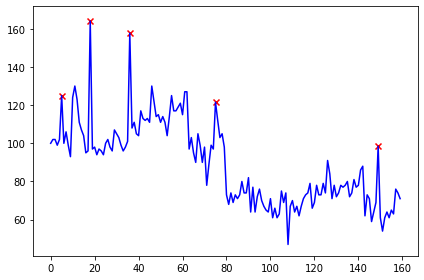

Test data index:  81  Error:  14305.639907836914


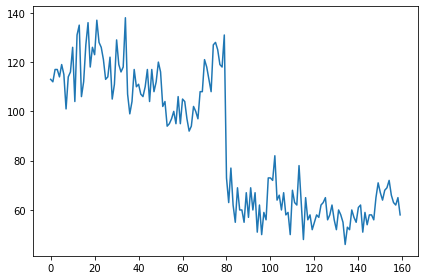

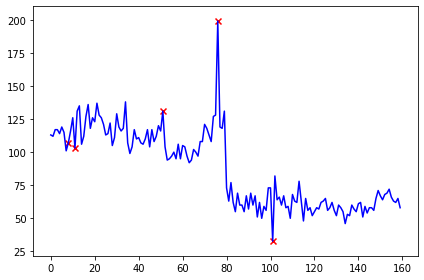

Test data index:  82  Error:  14001.089729309082


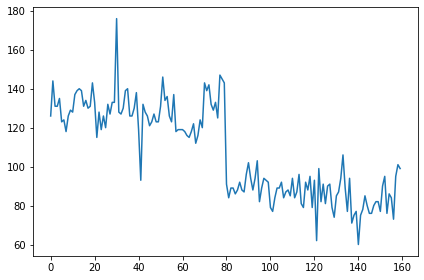

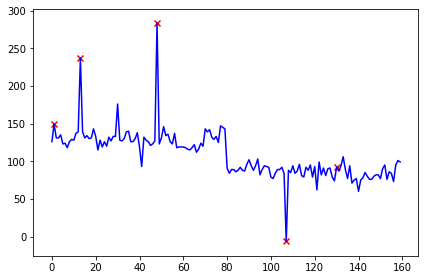

Test data index:  83  Error:  17413.07152748108


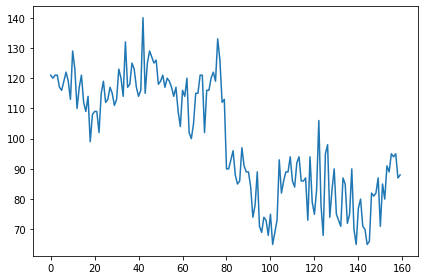

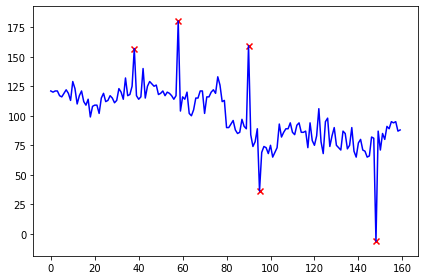

Test data index:  84  Error:  16018.974772930145


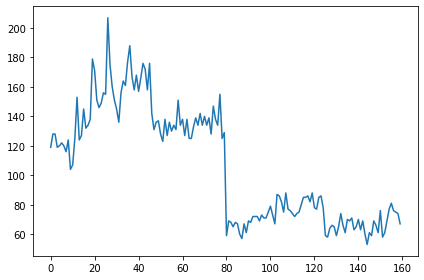

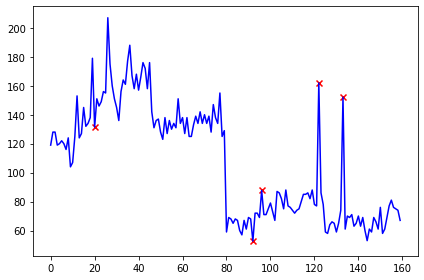

Test data index:  85  Error:  17178.947242736816


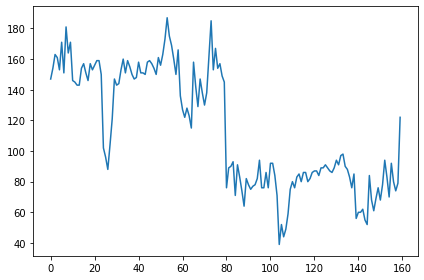

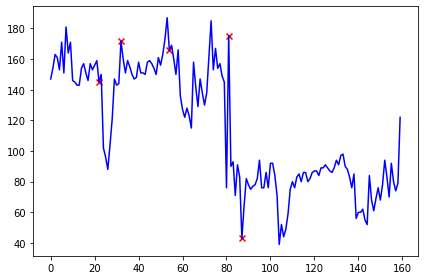

Test data index:  86  Error:  18322.218711853027


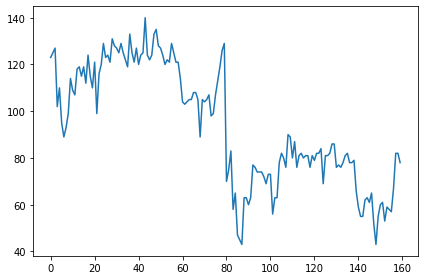

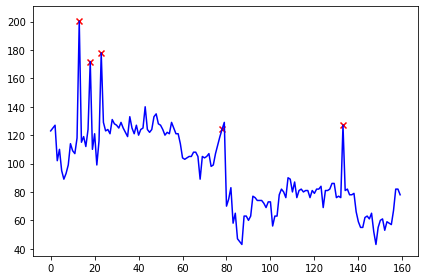

Test data index:  87  Error:  15264.2705078125


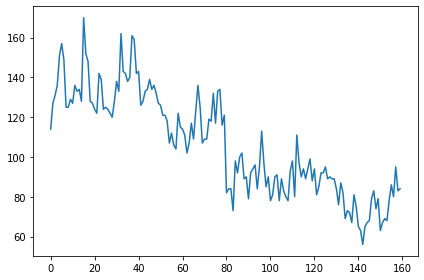

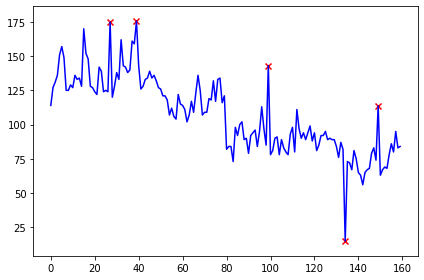

Test data index:  88  Error:  17152.25652694702


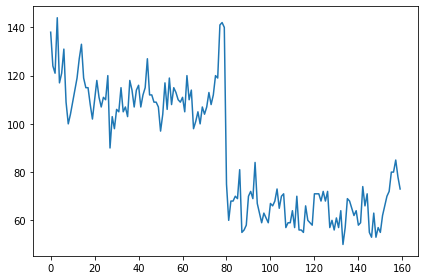

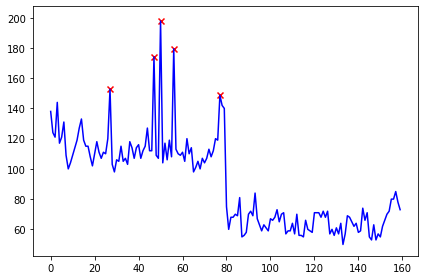

Test data index:  89  Error:  14539.67056274414


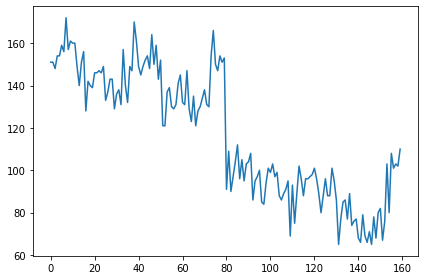

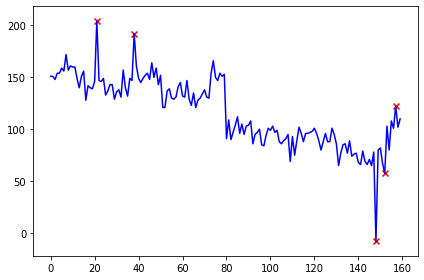

Test data index:  90  Error:  18729.76912546158


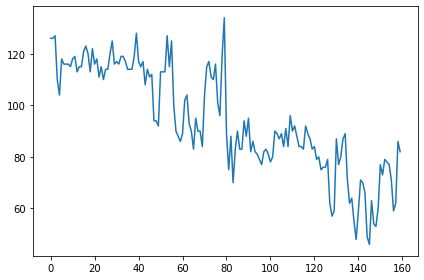

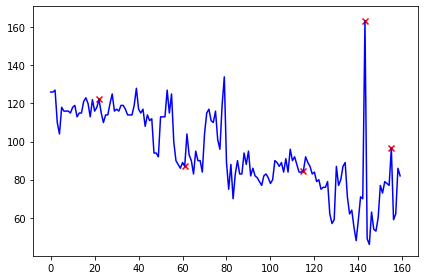

Test data index:  91  Error:  15189.850234985352


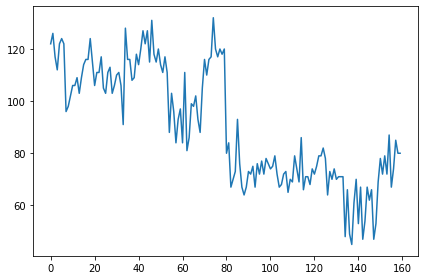

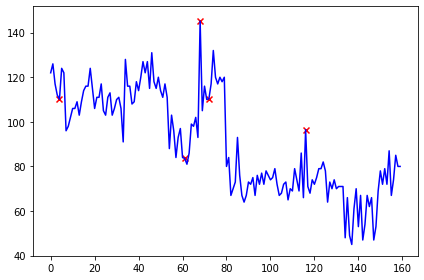

Test data index:  92  Error:  14499.781837463379


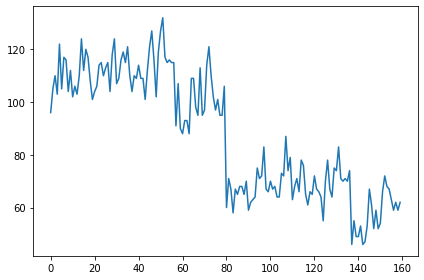

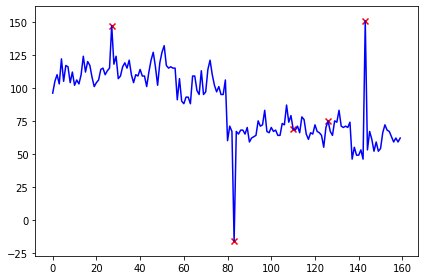

Test data index:  93  Error:  14067.797887802124


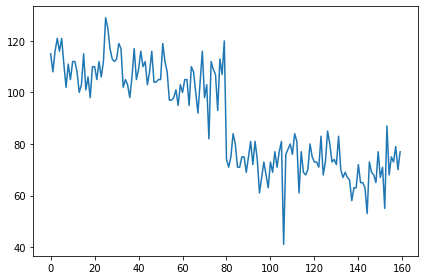

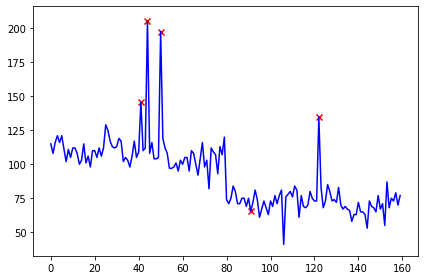

Test data index:  94  Error:  14638.113151550293


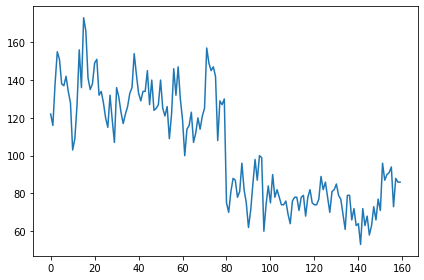

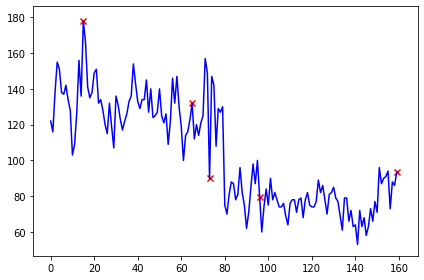

Test data index:  95  Error:  16634.794288635254


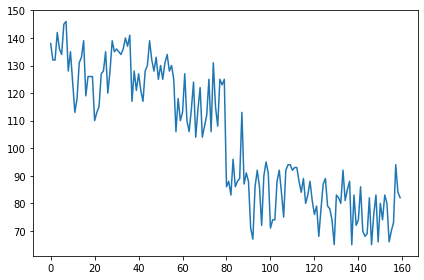

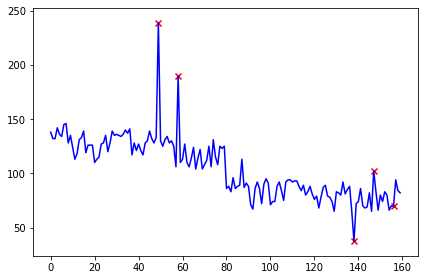

Test data index:  96  Error:  16756.774074554443


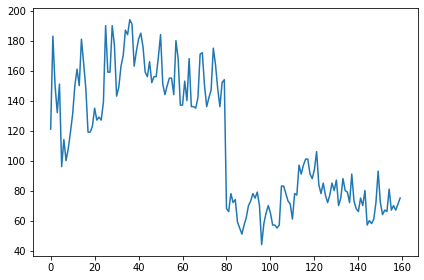

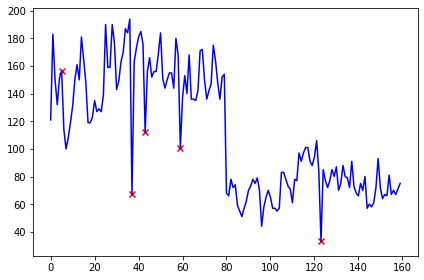

Test data index:  97  Error:  17894.650093078613


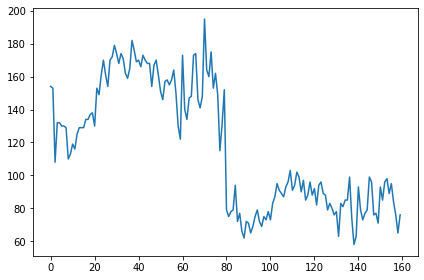

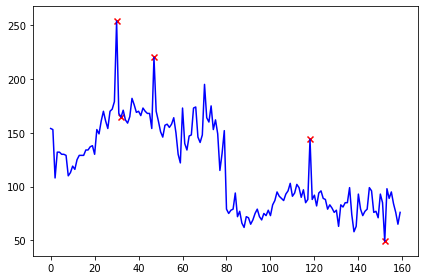

Test data index:  98  Error:  18854.493717193604


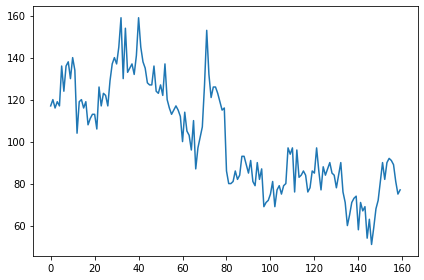

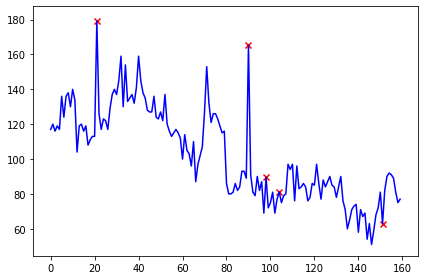

Test data index:  99  Error:  16429.983600616455


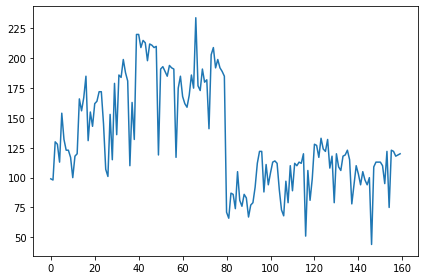

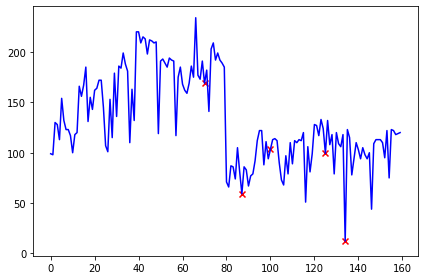

Test data index:  100  Error:  21265.677947998047


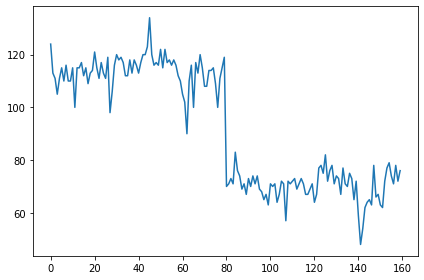

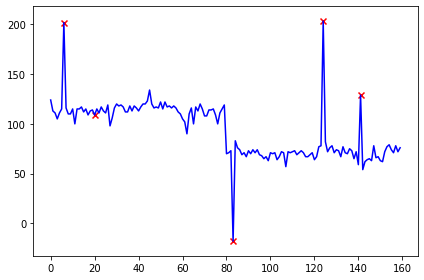

Test data index:  101  Error:  14953.723789215088


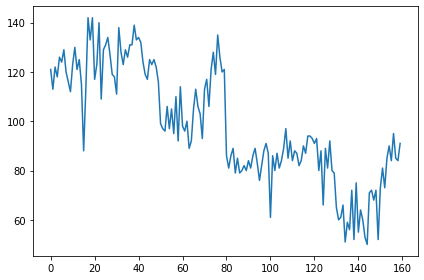

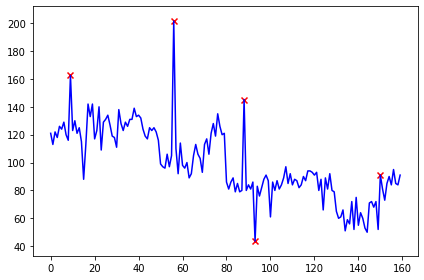

Test data index:  102  Error:  15923.947032928467


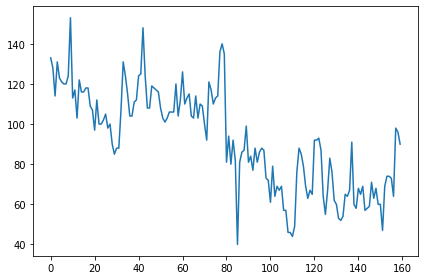

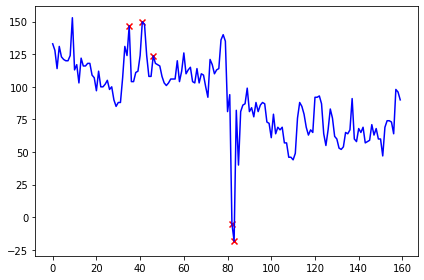

Test data index:  103  Error:  14669.633175373077


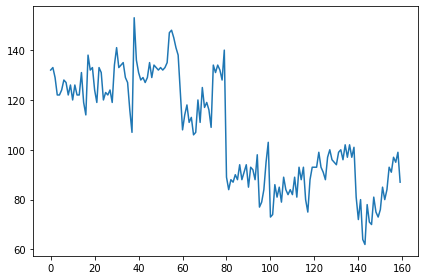

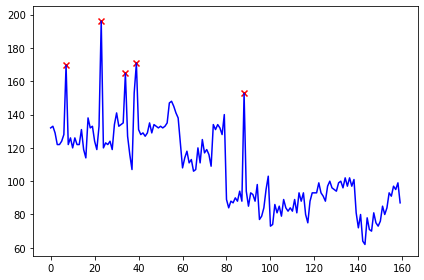

Test data index:  104  Error:  17389.99481201172


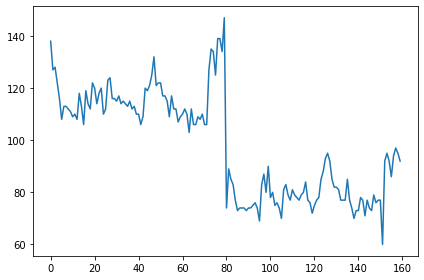

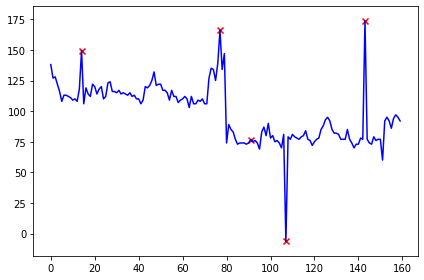

Test data index:  105  Error:  15793.960842609406


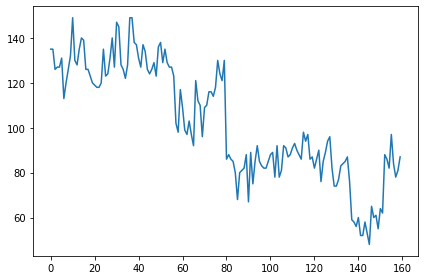

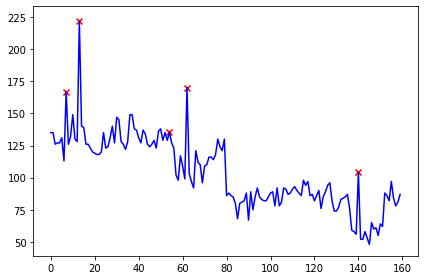

Test data index:  106  Error:  16602.03916168213


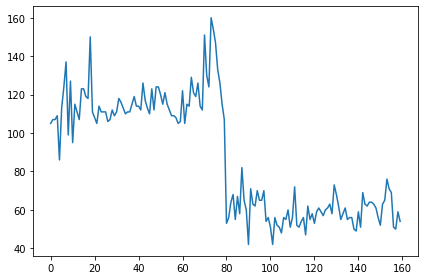

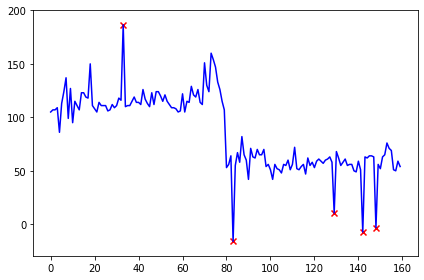

Test data index:  107  Error:  13903.479880571365


In [0]:
for index, real, missing, mask in zip(range(len(dados_pressao_completos)), dados_pressao_completos, X_test, X_test_masks):
    show_pressure_entries(np.array([real]))    
    imputed_samples = plot_imputed_pressures(gi, np.array([missing]), np.array([mask]), 1)
    print("Test data index: ", index, " Error: ", error_metric(real, imputed_samples[0], mask))

Salvando as redes treinadas para poder utilizar transfer learning futuramente.

In [0]:
# Save all weights
g.save_weights('model_g_weights.h5')
d.save_weights('model_d_weights.h5')
gan.save_weights('model_gan_weights.h5')
gi.save_weights('my_model_weights.h5')
di.save_weights('my_model_weights.h5')
ganI.save_weights('my_model_weights.h5')